In [32]:
import sys
sys.path.insert(0,'../')
from utilityLib.utilitycga import *

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

    
## define the nonlinearity 
def nonlinear(v):
    return torch.sinh(v)

def nonlinear_prime(v):
    return torch.cosh(v)

In [33]:

def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 

In [34]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    random_value = torch.randint(0, 2, (N,)) * 2 - 1 # +1 or -1  
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = random_value[:]
    relu_dict_parameters[:N,1] = (torch.rand(N)*(x_r-x_l) + x_l)*random_value # relu(x-bi) 
    # torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)
    
    return relu_dict_parameters

In [60]:
def H1_projection_init(model,sol, weights,integration_points,activation = 'relu', solver = 'direct'):
    """
    the first n-1 neurons gives the target function for the H1 projection 
    """
    #assemble the projection matrix using the basis functions 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2

    rhs = jac[:,:-1] @ sol.t() 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)

    model.fc2.weight.data[0,:] = sol[0,:] 
    return model 

def L2_projection_init(model,sol, weights,integration_points,activation = 'relu', solver = 'direct'):
    """
    the first n-1 neurons gives the target function for the H1 projection 
    """
    #assemble the projection matrix using the basis functions 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    jac = jac2

    rhs = jac[:,:-1] @ sol.t() 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)

    model.fc2.weight.data[0,:] = sol[0,:] 
    return model 


def minimize_linear_layer_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2


    rhs1 = weighted_basis_value_col.t() @ (target(integration_points) )
    print("rhs1 ",rhs1.size()) 
    # Neumman boundary condition
    basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
    rhs2 =  weighted_basis_value_col_bd.t() @ dudn
    print("rhs2 ",rhs2.size()) 
    rhs = rhs1 + rhs2 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

def minimize_linear_layer_newton_method_pbe(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    newton_iters = 20

    # neumann boundary condition 
    if g_N != None:
        basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
        weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
        dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
        rhs3 =  weighted_basis_value_col_bd.t() @ dudn
    else:
        rhs3 = 0 
    
    for i in range(newton_iters): 
        print("newton iteration: ", i+1) 
        # coef_func = 3 * model(integration_points).detach()**2 #changing after each newton iteration 
        coef_func = nonlinear_prime(model(integration_points).detach()) #changing after each newton iteration
        jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

        # stiffness matrix 
        if activation == 'relu':
            basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
            if model.k == 1:  
                basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
            else: 
                basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
        weighted_basis_value_dx_col = basis_value_dx_col * weights
        jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
        jac = jac1 + jac2

        rhs1 = weighted_basis_value_col.t() @ (target(integration_points) - nonlinear(model(integration_points).detach()) )


        if model!= None:
            dmy_model_dx1 = model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx1_boundary = model.evaluate_derivative(integration_points_bd,1).detach() * (torch.tensor([-1.,1.]).view(-1,1).to(device))
            rhs2 =  - weighted_basis_value_dx_col.t() @ dmy_model_dx1 # gradient term 
            rhs = rhs1 + rhs2 +rhs3   
        else: 
            rhs = rhs1 +rhs3 

        # print("assembling the matrix time taken: ", time.time()-start_time) 
        start_time = time.time()    
        if solver == "cg": 
            sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
            sol = torch.tensor(sol).view(1,-1)
        elif solver == "direct": 
    #         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
            sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
        elif solver == "ls":
            sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
            # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
        # print("solving Ax = b time taken: ", time.time()-start_time)
        ## update the solution 
        print(sol.size())
        # print(sol)
        model.fc2.weight.data[0,:] += sol[0,:]

        # print("newton iteration: ", i) 
        sol_update_l2_norm = torch.norm(sol)
        nn_linear_layer_l2_norm = torch.norm(model.fc2.weight.data[0,:])
        residual_l2_norm = torch.norm(rhs) 
        # print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        tol = 1e-11
        print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        if sol_update_l2_norm < tol*nn_linear_layer_l2_norm or sol_update_l2_norm < tol or residual_l2_norm < tol*1e-3: 
            print("converged at iteration: ", i+1 )
            print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
            return model.fc2.weight.data[:,:] 
    print("Newton solver NOT converged at iteration!!! ")
    print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))

    return model.fc2.weight.data[:,:] 


## Convergence order test 

In [36]:
def Neumann_boundary_quadrature_points(M, dim):
    """
    the boundary is in dimension dim - 1. 
    If 1D problem, the boundary is 0D, the quadrature points are 0 and 1. 
    """
    if dim == 1: 
        weights_bd = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd = torch.tensor([0.,1.]).view(-1,1).to(device) 
    
    return weights_bd.to(device), integration_points_bd.to(device) 

weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(2,1)
print(weights_bd)
print(integration_points_bd) 



tensor([[1.],
        [1.]], device='cuda:0')
tensor([[0.],
        [1.]], device='cuda:0')


In [37]:

torch.set_printoptions(precision=7)
def test_Neumann_linear():

    # def u_exact(x):
    #     return torch.cos(2*pi*x)

    # def du_exact(x):
    #     return -2*pi*torch.sin(2*pi*x) 
    # def rhs_neumann(x):
    #     return  ((2*pi)**2 * torch.cos(2*pi*x) + torch.cos(2*pi*x))*1 

    freq = 4 
    ## Problem 1 
    # def u_exact(x):
    #     return torch.cos(freq*pi*x)

    # def du_exact(x):
    #     return -freq*pi*torch.sin(freq*pi*x) 
    # def rhs_neumann(x):
    #     return  ((freq*pi)**2 * torch.cos(freq*pi*x) + torch.cos(freq*pi*x))*1 
    # def g_N(x): 
    #     return du_exact(x) 

    ## Problem 2 
    def u_exact(x):
        return torch.sin(freq*pi*x)

    def du_exact(x):
        return freq*pi*torch.cos(freq*pi*x) 
    def rhs_neumann(x):
        return  ((freq*pi)**2 * torch.sin(freq*pi*x) + torch.sin(freq*pi*x))*1 
    def g_N(x): 
        return du_exact(x) 
    
    weights, integration_points = PiecewiseGQ1D_weights_points(0,1,16000,4) 

    # Neumann boundary condition 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(2,1)

    h10_norm = torch.sum( (du_exact(integration_points))**2*weights)**0.5 
    print("h10_norm: ", h10_norm) 
    for neuron_nums in  [8,16,32,64,128,256,512]: 
        print("neuron_nums: ", neuron_nums)
        relu_k = 1 
        my_model = model(1,neuron_nums,1,k=relu_k ).to(device) 
        my_model.fc1.weight.data[:,0] = torch.ones(neuron_nums)[:] 
        my_model.fc1.bias.data[:] = - ( torch.linspace(0,1,neuron_nums)[:]  - (relu_k +1)/(neuron_nums) ) 
        
        sol = minimize_linear_layer_neumann(my_model,rhs_neumann,weights, integration_points, weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct') 
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err_l2 = torch.sum(func_values_sqrd*weights)**0.5
        err_h10 = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach()  - du_exact(integration_points) )**2*weights)**0.5 

        print(err_l2,err_h10) 
    return 0 

test_Neumann_linear()

h10_norm:  tensor(8.8857659, device='cuda:0')
neuron_nums:  8
rhs1  torch.Size([8, 1])
rhs2  torch.Size([8, 1])
assembling the matrix time taken:  0.0006842613220214844
solving Ax = b time taken:  0.0001614093780517578
tensor(0.3635318, device='cuda:0') tensor(5.8594173, device='cuda:0')
neuron_nums:  16
rhs1  torch.Size([16, 1])
rhs2  torch.Size([16, 1])
assembling the matrix time taken:  0.0006575584411621094
solving Ax = b time taken:  0.00014543533325195312
tensor(0.0649141, device='cuda:0') tensor(2.4126067, device='cuda:0')
neuron_nums:  32
rhs1  torch.Size([32, 1])
rhs2  torch.Size([32, 1])
assembling the matrix time taken:  0.0006201267242431641
solving Ax = b time taken:  0.00022745132446289062
tensor(0.0114832, device='cuda:0') tensor(1.0622023, device='cuda:0')
neuron_nums:  64
rhs1  torch.Size([64, 1])
rhs2  torch.Size([64, 1])
assembling the matrix time taken:  0.0009891986846923828
solving Ax = b time taken:  0.0003604888916015625
tensor(0.0025766, device='cuda:0') tensor

0

assembling the matrix time taken:  0.00034427642822265625
solving Ax = b time taken:  0.00017762184143066406
newton iteration:  1
torch.Size([1, 8])
sol_update_l2_norm:14.85320922616555 	 residual l2 norm: 0.645493384514496 
newton iteration:  2
torch.Size([1, 8])
sol_update_l2_norm:0.010359364887313195 	 residual l2 norm: 0.0019804808989957 
newton iteration:  3
torch.Size([1, 8])
sol_update_l2_norm:8.230102985784016e-08 	 residual l2 norm: 6.279182822856938e-09 
newton iteration:  4
torch.Size([1, 8])
sol_update_l2_norm:7.314217435581203e-13 	 residual l2 norm: 7.37898841919003e-15 
converged at iteration:  4
sol_update_l2_norm:7.314217435581203e-13 	 residual l2 norm: 7.37898841919003e-15 


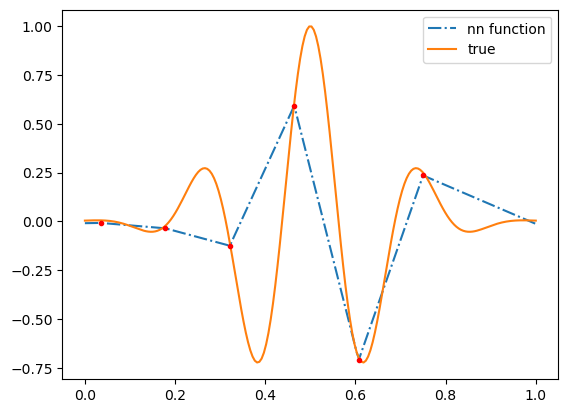

tensor(0.3312780, device='cuda:0') tensor(8.0528475, device='cuda:0')
assembling the matrix time taken:  0.0002758502960205078
solving Ax = b time taken:  0.0002830028533935547
newton iteration:  1
torch.Size([1, 16])
sol_update_l2_norm:17.22998155563712 	 residual l2 norm: 0.5361857351910596 
newton iteration:  2
torch.Size([1, 16])
sol_update_l2_norm:0.009859071040294732 	 residual l2 norm: 0.0005526308529605471 
newton iteration:  3
torch.Size([1, 16])
sol_update_l2_norm:3.798208011994546e-08 	 residual l2 norm: 2.1959595313633398e-09 
newton iteration:  4
torch.Size([1, 16])
sol_update_l2_norm:1.9623916874489978e-12 	 residual l2 norm: 1.2473931405303676e-14 
converged at iteration:  4
sol_update_l2_norm:1.9623916874489978e-12 	 residual l2 norm: 1.2473931405303676e-14 


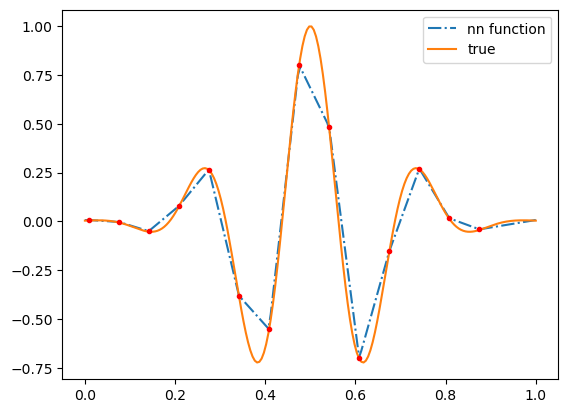

tensor(0.0951223, device='cuda:0') tensor(4.6004936, device='cuda:0')
assembling the matrix time taken:  0.0002713203430175781
solving Ax = b time taken:  0.0006680488586425781
newton iteration:  1
torch.Size([1, 32])
sol_update_l2_norm:19.700829849221385 	 residual l2 norm: 0.9585684888682399 
newton iteration:  2
torch.Size([1, 32])
sol_update_l2_norm:0.04730572651451628 	 residual l2 norm: 0.0017227390797643423 
newton iteration:  3
torch.Size([1, 32])
sol_update_l2_norm:5.753705312911419e-07 	 residual l2 norm: 2.0845929113395524e-08 
newton iteration:  4
torch.Size([1, 32])
sol_update_l2_norm:2.0581391319742052e-11 	 residual l2 norm: 1.6368110397934213e-14 
converged at iteration:  4
sol_update_l2_norm:2.0581391319742052e-11 	 residual l2 norm: 1.6368110397934213e-14 


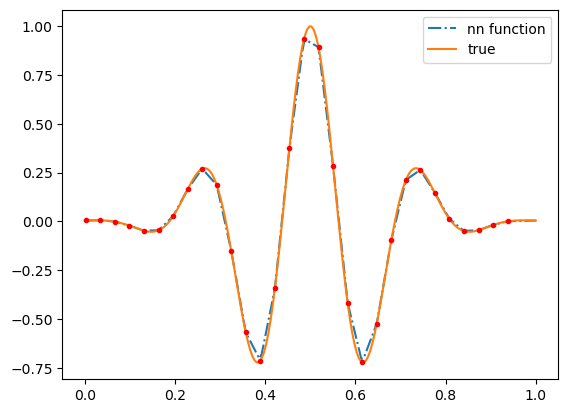

tensor(0.0236433, device='cuda:0') tensor(2.3304433, device='cuda:0')
assembling the matrix time taken:  0.0002789497375488281
solving Ax = b time taken:  0.0014190673828125
newton iteration:  1
torch.Size([1, 64])
sol_update_l2_norm:15.448641402248395 	 residual l2 norm: 1.430149405828286 
newton iteration:  2
torch.Size([1, 64])
sol_update_l2_norm:0.1135971638075 	 residual l2 norm: 0.0026325137472791274 
newton iteration:  3
torch.Size([1, 64])
sol_update_l2_norm:1.7765140304266053e-06 	 residual l2 norm: 4.123453778898008e-08 
newton iteration:  4
torch.Size([1, 64])
sol_update_l2_norm:7.197087122233205e-11 	 residual l2 norm: 1.5734440108327924e-14 
converged at iteration:  4
sol_update_l2_norm:7.197087122233205e-11 	 residual l2 norm: 1.5734440108327924e-14 


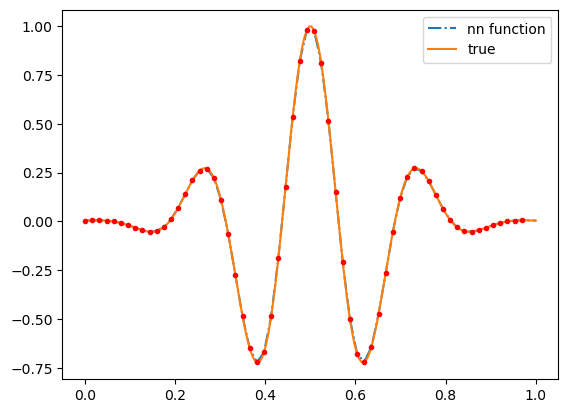

tensor(0.0058044, device='cuda:0') tensor(1.1591017, device='cuda:0')
assembling the matrix time taken:  0.0002994537353515625
solving Ax = b time taken:  0.003317594528198242
newton iteration:  1
torch.Size([1, 128])
sol_update_l2_norm:11.182327227329063 	 residual l2 norm: 2.051936410435341 
newton iteration:  2
torch.Size([1, 128])
sol_update_l2_norm:0.23848463246161122 	 residual l2 norm: 0.003690632966806604 
newton iteration:  3
torch.Size([1, 128])
sol_update_l2_norm:3.965667084984037e-06 	 residual l2 norm: 6.153765641687054e-08 
newton iteration:  4
torch.Size([1, 128])
sol_update_l2_norm:5.845578047461159e-10 	 residual l2 norm: 2.520335950893574e-13 
converged at iteration:  4
sol_update_l2_norm:5.845578047461159e-10 	 residual l2 norm: 2.520335950893574e-13 


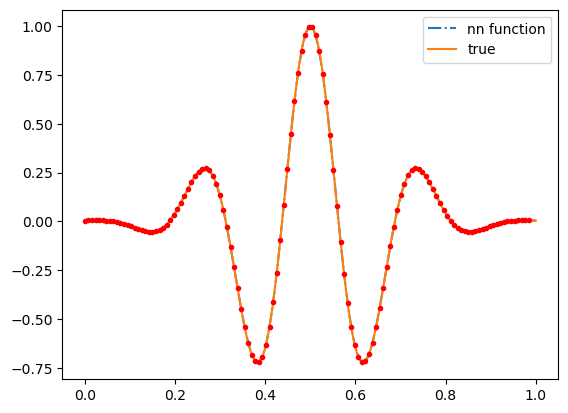

tensor(0.0014348, device='cuda:0') tensor(0.5764838, device='cuda:0')
assembling the matrix time taken:  0.0002732276916503906
solving Ax = b time taken:  0.008144140243530273
newton iteration:  1
torch.Size([1, 256])
sol_update_l2_norm:8.074860105458388 	 residual l2 norm: 2.9150050532448195 
newton iteration:  2
torch.Size([1, 256])
sol_update_l2_norm:0.48365106123026924 	 residual l2 norm: 0.005137486997173953 
newton iteration:  3
torch.Size([1, 256])
sol_update_l2_norm:8.167102945478796e-06 	 residual l2 norm: 8.703431078550459e-08 
newton iteration:  4
torch.Size([1, 256])
sol_update_l2_norm:5.487124394072625e-10 	 residual l2 norm: 3.20405610282929e-13 
converged at iteration:  4
sol_update_l2_norm:5.487124394072625e-10 	 residual l2 norm: 3.20405610282929e-13 


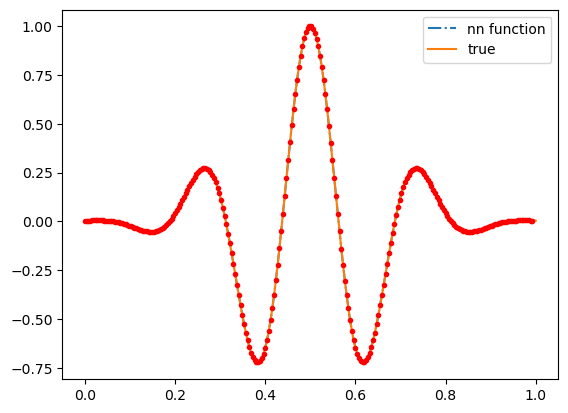

tensor(0.0003561, device='cuda:0') tensor(0.2873144, device='cuda:0')


0

In [53]:

def test_nonlinear_pbe():
## test Newton solver 
    # problem settings
    freq = 2 
    # def u_exact(x):
    #     return torch.sin(freq*pi*x)

    # def du_exact(x):
    #     return freq*pi*torch.cos(freq*pi*x) 
    # def u_exact_approx(x):
    #     return torch.sin(freq*pi*x)

    # def rhs(x):
    #     return  (freq*pi)**2 * torch.sin(freq*pi*x) + torch.sin(freq*pi*x)**3   

    # def rhs_neumann(x):
    #     return  ((freq*pi)**2 * torch.sin(freq*pi*x) + torch.sin(freq*pi*x))*0.5  

    # def g_N(x): 
    #     return du_exact(x) 
    
    # relu nn 
    relu_k = 1  
    alpha = 40 
    ## the nonlinearity is defined gloablly 

#     # define the manufacture solution and other pde terms 
#     def u_exact(x):
#         return torch.arctan(alpha * (x-0.5))
    
#     def u_exact_approx(x):
#         return torch.arctan(alpha * (x-0.5))*0.5 
    
#     def du_exact(x):
#         return alpha/(1+(alpha*(x-0.5))**2)
#     def laplace_u_exact(x):
#         return -2*alpha**3*(x-0.5)/(1+(alpha*(x-0.5))**2)**2

#     def rhs(x):
#         return  -laplace_u_exact(x) + nonlinear(u_exact(x))

#     def g_N(x):
#         return du_exact(x) 

    sigma = 0.15
    m = 4

    def u_exact(x):
        """Gabor function applied to a batch of points."""
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
        return exp_term * cos_term
    
    def u_exact_approx(x):
        return  u_exact(x)*0.5 
    
    def du_exact(x):
        """First derivative of the Gabor function with respect to each component for a batch of points."""
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        # Derivative with respect to x_1
        du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)

        # Derivative with respect to other dimensions
        du_dx_other = exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term

        # Concatenate all the derivatives to keep dimension
        du_dx = torch.cat([du_dx1, du_dx_other], dim=1)

        return du_dx

    def laplace_u_exact(x):
        """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
        exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
        cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
        sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

        exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term 
        - (2 * math.pi * m * exp_term * sin_term) 
        # Laplacian in x_1: Apply the product rule twice
        laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
        laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
        laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
        laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
        laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)
        
        laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                    + laplace_x1_part_4 + laplace_x1_part_5

        # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
        laplace_other = (-1 / sigma ** 2) * exp_term * (((x[:, 1:] - 0.5) ** 2 / sigma ** 2) - 1) * cos_term \
                    + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

        # Sum all Laplacians over each variable to get the total Laplacian
        laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

        return laplace_sum 

    def rhs(x):
        """Right-hand side of the equation using the Gabor function for a batch of points."""
        laplace_sum = laplace_u_exact(x)
        return -laplace_sum + nonlinear(u_exact(x))

    def g_N(x):
        return du_exact(x) 
    
    weights, integration_points = PiecewiseGQ1D_weights_points(0,1,80000,4) 

    # Neumann boundary condition 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(2,1)

    for neuron_nums in  [8,16,32,64,128,256]: 

        my_model = model(1,neuron_nums,1,k=relu_k).to(device) 

        my_model.fc1.weight.data[:,0] = torch.ones(neuron_nums)[:] 
        my_model.fc1.bias.data[:] = - ( torch.linspace(0,1,neuron_nums)[:]  - (relu_k+1)/(neuron_nums) )
        my_model.fc2.weight.data[0,:] = 0.001

        # x_test = torch.linspace(0,1,200).view(-1,1).to(device)
        # plt.plot(x_test.cpu(),my_model(x_test).cpu().detach())
        # plt.show()

        sol = minimize_linear_layer_explicit_assemble(my_model,u_exact_approx,weights, integration_points,solver="direct")
        # sol = minimize_linear_layer_neumann(my_model,rhs_neumann,weights, integration_points,activation = 'relu', solver = 'direct')
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        sol = minimize_linear_layer_newton_method_pbe(my_model,rhs,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct')
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        x_test = torch.linspace(0,1,200).view(-1,1).to(device)
        u_true = u_exact(x_test)
        plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err_l2 = torch.sum(func_values_sqrd*weights)**0.5
        err_h10 = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach()  - du_exact(integration_points) )**2*weights)**0.5 
        print( err_l2, err_h10) 
        # boundary_points = torch.tensor([0.,1.]).view(-1,1).to(device)  
        # print(my_model.evaluate_derivative(boundary_points,1))
    return 0 
test_nonlinear_pbe()

In [38]:
def select_greedy_neuron_ind_pbe(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd,k): 

    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values += nonlinear(my_model(integration_points).detach()) # pbe  

    weight_func_values = residual_values*weights

    basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
    
    output1 = torch.matmul(basis_values,weight_func_values) # 

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1], ZERO) * relu_dict_parameters.t()[0:1,:]   
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-1) * relu_dict_parameters.t()[0:1,:] 

    weight_dbasis_values_dx1 =  dbasis_values_dx1 * weights
    
    # Neumann boundary condition 
    basis_values_bd_col = (F.relu(relu_dict_parameters[:,0] *integration_points_bd - relu_dict_parameters[:,1])**k) 
    print(basis_values_bd_col.size())

    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device)
    output3 =  weighted_basis_value_col_bd.t() @ dudn


    if my_model!= None:
        dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output = torch.abs(output1 + output2 - output3)
        print("two outputs")
    else:
        output = torch.abs(output1 - output3)
        print("one output")
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 

def CGAPBEReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)

        start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind_pbe(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        
        print("argmax time: ", time.time() - start_argmax) 
        print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,:num_neuron ] = 0.0001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
            my_model = L2_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method_pbe(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


## randomized CGA 

def CGARandPBEReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [0,1]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    # relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        relu_dict_parameters = relu_dict_MC(0,1,N).to(device)  
        print('epoch: ',i+1)

        start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind_pbe(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        
        print("argmax time: ", time.time() - start_argmax) 
        print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,:num_neuron ] = 0.0001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
            my_model = L2_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method_pbe(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


## test randomized CGA

using linear solver:  direct
epoch:  1
torch.Size([2, 1024])
one output
argmax time:  0.0029838085174560547
selected neuron index:  tensor(5, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9960265, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:1.6084210562803298 	 residual l2 norm: 3.061553131198894 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.02745374311757649 	 residual l2 norm: 0.055249574686316194 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:2.8787874723248343e-05 	 residual l2 norm: 5.7813741721091105e-05 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:3.1104732725619195e-11 	 residual l2 norm: 6.246647643592951e-11 
converged at iteration:  4
sol_update_l2_norm:3.1104732725619195e-11 	 residual l2 norm: 6.246647643592951e-11 
epoch:  2
torch.Size([2, 1024])
two outputs
argmax time:  0.0031800270080566406
selected neuron index:  tensor(617, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.00054

selected neuron index:  tensor(780, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0536136, device='cuda:0')
assembling the matrix time taken:  0.00016617774963378906
solving Ax = b time taken:  0.00019860267639160156
newton iteration:  1
torch.Size([1, 19])
sol_update_l2_norm:12.342933161328505 	 residual l2 norm: 5.135235115051559e-07 
newton iteration:  2
torch.Size([1, 19])
sol_update_l2_norm:6.284375943137739e-08 	 residual l2 norm: 7.632525771053536e-10 
newton iteration:  3
torch.Size([1, 19])
sol_update_l2_norm:9.933058064122198e-09 	 residual l2 norm: 2.0008506771745977e-15 
converged at iteration:  3
sol_update_l2_norm:9.933058064122198e-09 	 residual l2 norm: 2.0008506771745977e-15 
epoch:  20
torch.Size([2, 1024])
two outputs
argmax time:  0.003175020217895508
selected neuron index:  tensor(727, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2468130, device='cuda:0')
assembling the matrix time taken:  0.00015544891357421875
solving Ax = b time taken:  0.0001

torch.Size([1, 37])
sol_update_l2_norm:3.874945276656091e-07 	 residual l2 norm: 3.864016229799809e-15 
converged at iteration:  3
sol_update_l2_norm:3.874945276656091e-07 	 residual l2 norm: 3.864016229799809e-15 
epoch:  38
torch.Size([2, 1024])
two outputs
argmax time:  0.0031261444091796875
selected neuron index:  tensor(692, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4764013, device='cuda:0')
assembling the matrix time taken:  0.0001575946807861328
solving Ax = b time taken:  0.00024318695068359375
newton iteration:  1
torch.Size([1, 38])
sol_update_l2_norm:5.530171735526437 	 residual l2 norm: 1.2715465063920362e-07 
newton iteration:  2
torch.Size([1, 38])
sol_update_l2_norm:1.5400602912319444e-06 	 residual l2 norm: 4.482944992150034e-13 
newton iteration:  3
torch.Size([1, 38])
sol_update_l2_norm:5.354329949039342e-07 	 residual l2 norm: 5.8616218098747136e-15 
converged at iteration:  3
sol_update_l2_norm:5.354329949039342e-07 	 residual l2 norm: 5.861621809874713

newton iteration:  1
torch.Size([1, 56])
sol_update_l2_norm:4.595098403456798 	 residual l2 norm: 8.292072249019244e-07 
newton iteration:  2
torch.Size([1, 56])
sol_update_l2_norm:2.57767321163765e-05 	 residual l2 norm: 1.3971472321042597e-14 
converged at iteration:  2
sol_update_l2_norm:2.57767321163765e-05 	 residual l2 norm: 1.3971472321042597e-14 
epoch:  57
torch.Size([2, 1024])
two outputs
argmax time:  0.003142118453979492
selected neuron index:  tensor(952, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0187386, device='cuda:0')
assembling the matrix time taken:  0.00016021728515625
solving Ax = b time taken:  0.00031447410583496094
newton iteration:  1
torch.Size([1, 57])
sol_update_l2_norm:3.585151711369997 	 residual l2 norm: 1.1165850444823997e-06 
newton iteration:  2
torch.Size([1, 57])
sol_update_l2_norm:4.8570534361223155e-05 	 residual l2 norm: 4.1617955453643046e-14 
converged at iteration:  2
sol_update_l2_norm:4.8570534361223155e-05 	 residual l2 norm: 4.

selected neuron index:  tensor(764, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3744037, device='cuda:0')
assembling the matrix time taken:  0.00015974044799804688
solving Ax = b time taken:  0.00037479400634765625
newton iteration:  1
torch.Size([1, 75])
sol_update_l2_norm:7.1645305903886225 	 residual l2 norm: 3.2451661393911793e-06 
newton iteration:  2
torch.Size([1, 75])
sol_update_l2_norm:6.915983382885021e-05 	 residual l2 norm: 1.0590362924578907e-14 
converged at iteration:  2
sol_update_l2_norm:6.915983382885021e-05 	 residual l2 norm: 1.0590362924578907e-14 
epoch:  76
torch.Size([2, 1024])
two outputs
argmax time:  0.0031328201293945312
selected neuron index:  tensor(287, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7574989, device='cuda:0')
assembling the matrix time taken:  0.00015854835510253906
solving Ax = b time taken:  0.0003724098205566406
newton iteration:  1
torch.Size([1, 76])
sol_update_l2_norm:10.931238404417828 	 residual l2 norm: 5.203002

epoch:  93
torch.Size([2, 1024])
two outputs
argmax time:  0.0032296180725097656
selected neuron index:  tensor(149, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9517201, device='cuda:0')
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.0004425048828125
newton iteration:  1
torch.Size([1, 93])
sol_update_l2_norm:7.619735143550217 	 residual l2 norm: 2.5680321430704457e-06 
newton iteration:  2
torch.Size([1, 93])
sol_update_l2_norm:0.0015939446986980438 	 residual l2 norm: 1.4894647823125643e-14 
converged at iteration:  2
sol_update_l2_norm:0.0015939446986980438 	 residual l2 norm: 1.4894647823125643e-14 
epoch:  94
torch.Size([2, 1024])
two outputs
argmax time:  0.0031692981719970703
selected neuron index:  tensor(1006, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6747487, device='cuda:0')
assembling the matrix time taken:  0.0001678466796875
solving Ax = b time taken:  0.0004513263702392578
newton iteration:  1
torch.Size([1

two outputs
argmax time:  0.0032629966735839844
selected neuron index:  tensor(9, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0249866, device='cuda:0')
assembling the matrix time taken:  0.0001647472381591797
solving Ax = b time taken:  0.0005390644073486328
newton iteration:  1
torch.Size([1, 109])
sol_update_l2_norm:39.5619003883081 	 residual l2 norm: 5.65522030210199e-06 
newton iteration:  2
torch.Size([1, 109])
sol_update_l2_norm:0.010472145201382345 	 residual l2 norm: 5.593176924245294e-14 
converged at iteration:  2
sol_update_l2_norm:0.010472145201382345 	 residual l2 norm: 5.593176924245294e-14 
epoch:  110
torch.Size([2, 1024])
two outputs
argmax time:  0.003153562545776367
selected neuron index:  tensor(682, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5205594, device='cuda:0')
assembling the matrix time taken:  0.00016260147094726562
solving Ax = b time taken:  0.0005464553833007812
newton iteration:  1
torch.Size([1, 110])
sol_update_l2_norm:2099.170

two outputs
argmax time:  0.003263235092163086
selected neuron index:  tensor(304, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0472615, device='cuda:0')
assembling the matrix time taken:  0.00015425682067871094
solving Ax = b time taken:  0.0006225109100341797
newton iteration:  1
torch.Size([1, 123])
sol_update_l2_norm:948.1349148100517 	 residual l2 norm: 4.2141404164791175e-05 
newton iteration:  2
torch.Size([1, 123])
sol_update_l2_norm:0.19559647918869222 	 residual l2 norm: 2.7303761643400743e-12 
newton iteration:  3
torch.Size([1, 123])
sol_update_l2_norm:0.0011069488551417395 	 residual l2 norm: 4.752955445924041e-15 
converged at iteration:  3
sol_update_l2_norm:0.0011069488551417395 	 residual l2 norm: 4.752955445924041e-15 
epoch:  124
torch.Size([2, 1024])
two outputs
argmax time:  0.003137350082397461
selected neuron index:  tensor(938, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1725524, device='cuda:0')
assembling the matrix time taken:  0.00015401

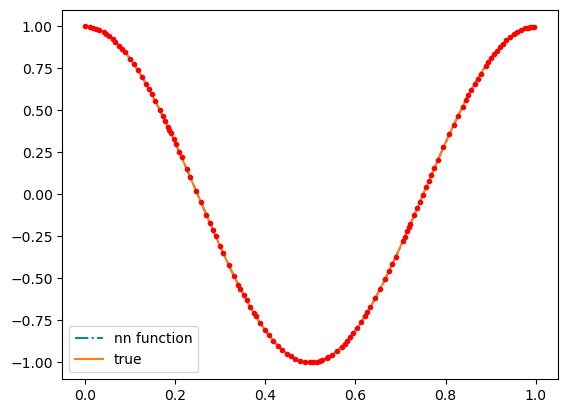

time taken:  1.6073338985443115
neuron num 		 error 		 order
4 		 0.101356 		 * 		 0.865022 		 * 

8 		 0.002931 		 5.111827 		 0.077169 		 3.486651 

16 		 0.000076 		 5.264640 		 0.004975 		 3.955282 

32 		 0.000005 		 3.897192 		 0.000630 		 2.980487 

64 		 0.000000 		 4.145586 		 0.000075 		 3.078881 

128 		 0.000000 		 3.943729 		 0.000011 		 2.804973 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.101356 &		 * & 		 0.865022 & 		 *  \\ \hline  

8 		 &  2.931e-03 &  		 5.11 &  		 7.717e-02 &  		 3.49 \\ \hline  

16 		 &  7.625e-05 &  		 5.26 &  		 4.975e-03 &  		 3.96 \\ \hline  

32 		 &  5.117e-06 &  		 3.90 &  		 6.303e-04 &  		 2.98 \\ \hline  

64 		 &  2.891e-07 &  		 4.15 &  		 7.460e-05 &  		 3.08 \\ \hline  

128 		 &  1.879e-08 &  		 3.94 &  		 1.067e-05 &  		 2.80 \\ \hline  



In [9]:
def u_exact(x):
    return torch.cos(2*pi*x)

def du_exact(x):
    return -2 *pi*torch.sin(2*pi*x)

def rhs(x):
    return  (2*pi)**2 * torch.cos(2*pi*x) + nonlinear(torch.cos(2*pi*x))

def g_N(x):
    return du_exact(x) 

function_name = "sine1d" 
filename_write = "data/1DRandCGA-PBE-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 
relu_k = 3
for N in [2**10]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**13
    order = 3   
    exponent = 7
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGARandPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k , solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

    

## Gabor function test 

The function is given by 
\begin{equation}
    \label{eq:gabor}
    u(x)  = \exp(-\frac{\sum_{i = 1}^d (x_i - 0.5)^2}{2 \sigma^2}) \cos(2\pi m x_1 ),  
\end{equation}
where $\sigma = 0.15$ and $ m = 8$, 


using linear solver:  direct
epoch:  1
torch.Size([2, 256])
one output
argmax time:  0.0019125938415527344
selected neuron index:  tensor(173, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5037497, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:1.7912696095110205 	 residual l2 norm: 0.9786623837328166 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.011479652556320313 	 residual l2 norm: 0.006397310843449251 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:1.508063701312258e-06 	 residual l2 norm: 8.401840854779796e-07 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:2.5220896815356533e-14 	 residual l2 norm: 1.4051260155412137e-14 
converged at iteration:  4
sol_update_l2_norm:2.5220896815356533e-14 	 residual l2 norm: 1.4051260155412137e-14 
epoch:  2
torch.Size([2, 256])
two outputs
argmax time:  0.0021848678588867188
selected neuron index:  tensor(91, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5621

torch.Size([1, 15])
sol_update_l2_norm:0.0007616571266167983 	 residual l2 norm: 0.0002471054006782222 
newton iteration:  3
torch.Size([1, 15])
sol_update_l2_norm:9.849257661586957e-09 	 residual l2 norm: 3.6013368952413926e-09 
newton iteration:  4
torch.Size([1, 15])
sol_update_l2_norm:5.431071227114666e-14 	 residual l2 norm: 1.255310010756526e-14 
converged at iteration:  4
sol_update_l2_norm:5.431071227114666e-14 	 residual l2 norm: 1.255310010756526e-14 
epoch:  16
torch.Size([2, 256])
two outputs
argmax time:  0.0021827220916748047
selected neuron index:  tensor(202, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4233657, device='cuda:0')
assembling the matrix time taken:  0.00016570091247558594
solving Ax = b time taken:  0.0001544952392578125
newton iteration:  1
torch.Size([1, 16])
sol_update_l2_norm:24.402551364011835 	 residual l2 norm: 0.24410901614935743 
newton iteration:  2
torch.Size([1, 16])
sol_update_l2_norm:8.923227371022631e-05 	 residual l2 norm: 1.46898

selected neuron index:  tensor(39, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6816216, device='cuda:0')
assembling the matrix time taken:  0.00016641616821289062
solving Ax = b time taken:  0.0002512931823730469
newton iteration:  1
torch.Size([1, 33])
sol_update_l2_norm:15.495484636136874 	 residual l2 norm: 0.07249542494255212 
newton iteration:  2
torch.Size([1, 33])
sol_update_l2_norm:2.9384716727962562e-05 	 residual l2 norm: 1.2949508387069986e-05 
newton iteration:  3
torch.Size([1, 33])
sol_update_l2_norm:2.772776425581485e-12 	 residual l2 norm: 2.316507081521685e-13 
converged at iteration:  3
sol_update_l2_norm:2.772776425581485e-12 	 residual l2 norm: 2.316507081521685e-13 
epoch:  34
torch.Size([2, 256])
two outputs
argmax time:  0.0021445751190185547
selected neuron index:  tensor(247, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5137491, device='cuda:0')
assembling the matrix time taken:  0.00016355514526367188
solving Ax = b time taken:  0.00025439

selected neuron index:  tensor(109, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5564707, device='cuda:0')
assembling the matrix time taken:  0.0001723766326904297
solving Ax = b time taken:  0.0002949237823486328
newton iteration:  1
torch.Size([1, 50])
sol_update_l2_norm:15.63380549759314 	 residual l2 norm: 0.0366207916022934 
newton iteration:  2
torch.Size([1, 50])
sol_update_l2_norm:2.031567801794427e-06 	 residual l2 norm: 1.118356208102582e-06 
newton iteration:  3
torch.Size([1, 50])
sol_update_l2_norm:3.2771683588806697e-12 	 residual l2 norm: 4.274794282672969e-14 
converged at iteration:  3
sol_update_l2_norm:3.2771683588806697e-12 	 residual l2 norm: 4.274794282672969e-14 
epoch:  51
torch.Size([2, 256])
two outputs
argmax time:  0.002151966094970703
selected neuron index:  tensor(208, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3912479, device='cuda:0')
assembling the matrix time taken:  0.00016498565673828125
solving Ax = b time taken:  0.00030279159

selected neuron index:  tensor(173, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4154077, device='cuda:0')
assembling the matrix time taken:  0.00017380714416503906
solving Ax = b time taken:  0.0004668235778808594
newton iteration:  1
torch.Size([1, 66])
sol_update_l2_norm:4.937132911398827 	 residual l2 norm: 0.022346687047817507 
newton iteration:  2
torch.Size([1, 66])
sol_update_l2_norm:6.770522728558939e-07 	 residual l2 norm: 5.150019874748068e-07 
newton iteration:  3
torch.Size([1, 66])
sol_update_l2_norm:2.7433207668251615e-12 	 residual l2 norm: 5.699138991157843e-14 
converged at iteration:  3
sol_update_l2_norm:2.7433207668251615e-12 	 residual l2 norm: 5.699138991157843e-14 
epoch:  67
torch.Size([2, 256])
two outputs
argmax time:  0.002171754837036133
selected neuron index:  tensor(185, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4992588, device='cuda:0')
assembling the matrix time taken:  0.0001690387725830078
solving Ax = b time taken:  0.000471115

selected neuron index:  tensor(8, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7825608, device='cuda:0')
assembling the matrix time taken:  0.00017595291137695312
solving Ax = b time taken:  0.0005781650543212891
newton iteration:  1
torch.Size([1, 81])
sol_update_l2_norm:3.0271839651031 	 residual l2 norm: 0.01448599298881875 
newton iteration:  2
torch.Size([1, 81])
sol_update_l2_norm:9.403826183269233e-08 	 residual l2 norm: 5.238173407595888e-08 
newton iteration:  3
torch.Size([1, 81])
sol_update_l2_norm:4.532643757300692e-12 	 residual l2 norm: 2.0211655038828717e-14 
converged at iteration:  3
sol_update_l2_norm:4.532643757300692e-12 	 residual l2 norm: 2.0211655038828717e-14 
epoch:  82
torch.Size([2, 256])
two outputs
argmax time:  0.002197265625
selected neuron index:  tensor(85, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4907909, device='cuda:0')
assembling the matrix time taken:  0.00017523765563964844
solving Ax = b time taken:  0.000576019287109375
n

torch.Size([2, 256])
two outputs
argmax time:  0.0025506019592285156
selected neuron index:  tensor(221, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3872289, device='cuda:0')
assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.0006618499755859375
newton iteration:  1
torch.Size([1, 95])
sol_update_l2_norm:6.674126016536713 	 residual l2 norm: 0.009738870993507464 
newton iteration:  2
torch.Size([1, 95])
sol_update_l2_norm:7.095815095230699e-08 	 residual l2 norm: 2.8611344386084835e-08 
newton iteration:  3
torch.Size([1, 95])
sol_update_l2_norm:1.3605964871417545e-11 	 residual l2 norm: 5.358466353634384e-14 
converged at iteration:  3
sol_update_l2_norm:1.3605964871417545e-11 	 residual l2 norm: 5.358466353634384e-14 
epoch:  96
torch.Size([2, 256])
two outputs
argmax time:  0.0022497177124023438
selected neuron index:  tensor(189, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3252380, device='cuda:0')
assembling the matrix time

torch.Size([2, 256])
two outputs
argmax time:  0.0025904178619384766
selected neuron index:  tensor(20, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6080050, device='cuda:0')
assembling the matrix time taken:  0.00017786026000976562
solving Ax = b time taken:  0.0007143020629882812
newton iteration:  1
torch.Size([1, 108])
sol_update_l2_norm:6.174517619319195 	 residual l2 norm: 0.008146978934575314 
newton iteration:  2
torch.Size([1, 108])
sol_update_l2_norm:5.422715476078334e-08 	 residual l2 norm: 6.667997857548063e-08 
newton iteration:  3
torch.Size([1, 108])
sol_update_l2_norm:1.715579054154234e-11 	 residual l2 norm: 4.937424817756992e-14 
converged at iteration:  3
sol_update_l2_norm:1.715579054154234e-11 	 residual l2 norm: 4.937424817756992e-14 
epoch:  109
torch.Size([2, 256])
two outputs
argmax time:  0.002275705337524414
selected neuron index:  tensor(86, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5241011, device='cuda:0')
assembling the matrix time 

assembling the matrix time taken:  0.00017333030700683594
solving Ax = b time taken:  0.0007894039154052734
newton iteration:  1
torch.Size([1, 120])
sol_update_l2_norm:5.019034296892212 	 residual l2 norm: 0.006198648688086203 
newton iteration:  2
torch.Size([1, 120])
sol_update_l2_norm:3.114596765541271e-08 	 residual l2 norm: 4.389614038430703e-08 
newton iteration:  3
torch.Size([1, 120])
sol_update_l2_norm:7.891428705492194e-12 	 residual l2 norm: 3.2594068486470606e-14 
converged at iteration:  3
sol_update_l2_norm:7.891428705492194e-12 	 residual l2 norm: 3.2594068486470606e-14 
epoch:  121
torch.Size([2, 256])
two outputs
argmax time:  0.0022885799407958984
selected neuron index:  tensor(227, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4749647, device='cuda:0')
assembling the matrix time taken:  0.00016570091247558594
solving Ax = b time taken:  0.0008130073547363281
newton iteration:  1
torch.Size([1, 121])
sol_update_l2_norm:2.762196226664524 	 residual l2 norm: 0

torch.Size([1, 131])
sol_update_l2_norm:2.1241599979765714e-08 	 residual l2 norm: 2.6768997206745035e-08 
newton iteration:  3
torch.Size([1, 131])
sol_update_l2_norm:1.0618349508494798e-11 	 residual l2 norm: 4.643779896971224e-14 
converged at iteration:  3
sol_update_l2_norm:1.0618349508494798e-11 	 residual l2 norm: 4.643779896971224e-14 
epoch:  132
torch.Size([2, 256])
two outputs
argmax time:  0.002302885055541992
selected neuron index:  tensor(47, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7338410, device='cuda:0')
assembling the matrix time taken:  0.00016808509826660156
solving Ax = b time taken:  0.0010492801666259766
newton iteration:  1
torch.Size([1, 132])
sol_update_l2_norm:3.8841419887635142 	 residual l2 norm: 0.006534776894703787 
newton iteration:  2
torch.Size([1, 132])
sol_update_l2_norm:2.585767470660145e-08 	 residual l2 norm: 3.883892846927063e-08 
newton iteration:  3
torch.Size([1, 132])
sol_update_l2_norm:9.68611755226828e-12 	 residual l2 norm: 

selected neuron index:  tensor(226, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4001821, device='cuda:0')
assembling the matrix time taken:  0.00016641616821289062
solving Ax = b time taken:  0.0011255741119384766
newton iteration:  1
torch.Size([1, 142])
sol_update_l2_norm:4.207272842633568 	 residual l2 norm: 0.005664826051518755 
newton iteration:  2
torch.Size([1, 142])
sol_update_l2_norm:1.2269236107476998e-08 	 residual l2 norm: 1.7725510495054063e-08 
newton iteration:  3
torch.Size([1, 142])
sol_update_l2_norm:1.4600120561489813e-11 	 residual l2 norm: 1.077555458889342e-13 
converged at iteration:  3
sol_update_l2_norm:1.4600120561489813e-11 	 residual l2 norm: 1.077555458889342e-13 
epoch:  143
torch.Size([2, 256])
two outputs
argmax time:  0.0023224353790283203
selected neuron index:  tensor(58, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8099501, device='cuda:0')
assembling the matrix time taken:  0.00016260147094726562
solving Ax = b time taken:  0.00

torch.Size([1, 161])
sol_update_l2_norm:3.620295873965424e-09 	 residual l2 norm: 7.828503156885921e-09 
newton iteration:  3
torch.Size([1, 161])
sol_update_l2_norm:2.1590943411883517e-11 	 residual l2 norm: 6.678795900378367e-14 
converged at iteration:  3
sol_update_l2_norm:2.1590943411883517e-11 	 residual l2 norm: 6.678795900378367e-14 
epoch:  162
torch.Size([2, 256])
two outputs
argmax time:  0.002348184585571289
selected neuron index:  tensor(202, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3714309, device='cuda:0')
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.001285552978515625
newton iteration:  1
torch.Size([1, 162])
sol_update_l2_norm:4.159963564006378 	 residual l2 norm: 0.0041992529983582855 
newton iteration:  2
torch.Size([1, 162])
sol_update_l2_norm:1.795850445369892e-08 	 residual l2 norm: 2.8908263433083186e-08 
newton iteration:  3
torch.Size([1, 162])
sol_update_l2_norm:2.4648212771326378e-11 	 residual l2 norm:

torch.Size([1, 179])
sol_update_l2_norm:2.6591277974950053e-11 	 residual l2 norm: 1.0383363022295687e-13 
converged at iteration:  3
sol_update_l2_norm:2.6591277974950053e-11 	 residual l2 norm: 1.0383363022295687e-13 
epoch:  180
torch.Size([2, 256])
two outputs
argmax time:  0.0024118423461914062
selected neuron index:  tensor(158, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5870720, device='cuda:0')
assembling the matrix time taken:  0.0001652240753173828
solving Ax = b time taken:  0.0014007091522216797
newton iteration:  1
torch.Size([1, 180])
sol_update_l2_norm:1.4978213666234503 	 residual l2 norm: 0.0029798933400759227 
newton iteration:  2
torch.Size([1, 180])
sol_update_l2_norm:5.193369711900757e-09 	 residual l2 norm: 9.347702815881404e-09 
newton iteration:  3
torch.Size([1, 180])
sol_update_l2_norm:2.5734697141265765e-11 	 residual l2 norm: 5.725111729598227e-14 
converged at iteration:  3
sol_update_l2_norm:2.5734697141265765e-11 	 residual l2 norm: 5.72511172

torch.Size([1, 196])
sol_update_l2_norm:2.871361943005359 	 residual l2 norm: 0.002744131174542379 
newton iteration:  2
torch.Size([1, 196])
sol_update_l2_norm:3.6623359315367877e-09 	 residual l2 norm: 6.318600338389555e-09 
newton iteration:  3
torch.Size([1, 196])
sol_update_l2_norm:2.543340890009779e-11 	 residual l2 norm: 9.348006121265309e-14 
converged at iteration:  3
sol_update_l2_norm:2.543340890009779e-11 	 residual l2 norm: 9.348006121265309e-14 
epoch:  197
torch.Size([2, 256])
two outputs
argmax time:  0.0024411678314208984
selected neuron index:  tensor(200, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5554495, device='cuda:0')
assembling the matrix time taken:  0.0001697540283203125
solving Ax = b time taken:  0.0016443729400634766
newton iteration:  1
torch.Size([1, 197])
sol_update_l2_norm:4.777435299231156 	 residual l2 norm: 0.0027632626002191936 
newton iteration:  2
torch.Size([1, 197])
sol_update_l2_norm:6.450191702281339e-09 	 residual l2 norm: 1.1095

assembling the matrix time taken:  0.00016546249389648438
solving Ax = b time taken:  0.0017447471618652344
newton iteration:  1
torch.Size([1, 212])
sol_update_l2_norm:4.293763081549676 	 residual l2 norm: 0.002532444393782347 
newton iteration:  2
torch.Size([1, 212])
sol_update_l2_norm:3.1975015450479917e-09 	 residual l2 norm: 5.775123894406273e-09 
newton iteration:  3
torch.Size([1, 212])
sol_update_l2_norm:2.273337793038142e-11 	 residual l2 norm: 3.3301383182934904e-14 
converged at iteration:  3
sol_update_l2_norm:2.273337793038142e-11 	 residual l2 norm: 3.3301383182934904e-14 
epoch:  213
torch.Size([2, 256])
two outputs
argmax time:  0.002459287643432617
selected neuron index:  tensor(197, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7768024, device='cuda:0')
assembling the matrix time taken:  0.0001652240753173828
solving Ax = b time taken:  0.0017986297607421875
newton iteration:  1
torch.Size([1, 213])
sol_update_l2_norm:0.7142155379203163 	 residual l2 norm: 0

torch.Size([1, 227])
sol_update_l2_norm:3.2307330289864153 	 residual l2 norm: 0.0021241846627914128 
newton iteration:  2
torch.Size([1, 227])
sol_update_l2_norm:1.510688373342963e-09 	 residual l2 norm: 3.125836947784395e-09 
newton iteration:  3
torch.Size([1, 227])
sol_update_l2_norm:2.382426226929984e-11 	 residual l2 norm: 3.990271280667116e-14 
converged at iteration:  3
sol_update_l2_norm:2.382426226929984e-11 	 residual l2 norm: 3.990271280667116e-14 
epoch:  228
torch.Size([2, 256])
two outputs
argmax time:  0.002508401870727539
selected neuron index:  tensor(96, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3792293, device='cuda:0')
assembling the matrix time taken:  0.00017690658569335938
solving Ax = b time taken:  0.0018360614776611328
newton iteration:  1
torch.Size([1, 228])
sol_update_l2_norm:3.510215557724297 	 residual l2 norm: 0.002183052269951867 
newton iteration:  2
torch.Size([1, 228])
sol_update_l2_norm:1.6697509571365088e-09 	 residual l2 norm: 3.3938

assembling the matrix time taken:  0.00016570091247558594
solving Ax = b time taken:  0.001940011978149414
newton iteration:  1
torch.Size([1, 242])
sol_update_l2_norm:0.5510494870192952 	 residual l2 norm: 0.0019175998387963213 
newton iteration:  2
torch.Size([1, 242])
sol_update_l2_norm:1.8040989545173465e-10 	 residual l2 norm: 7.704688164683568e-10 
converged at iteration:  2
sol_update_l2_norm:1.8040989545173465e-10 	 residual l2 norm: 7.704688164683568e-10 
epoch:  243
torch.Size([2, 256])
two outputs
argmax time:  0.002493143081665039
selected neuron index:  tensor(59, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4295915, device='cuda:0')
assembling the matrix time taken:  0.0001647472381591797
solving Ax = b time taken:  0.0019583702087402344
newton iteration:  1
torch.Size([1, 243])
sol_update_l2_norm:3.542773629597746 	 residual l2 norm: 0.001915159826547624 
newton iteration:  2
torch.Size([1, 243])
sol_update_l2_norm:1.8488195016293031e-09 	 residual l2 norm: 3.7

solving Ax = b time taken:  0.002031087875366211
newton iteration:  1
torch.Size([1, 256])
sol_update_l2_norm:3.056751871344677 	 residual l2 norm: 0.00173550583145514 
newton iteration:  2
torch.Size([1, 256])
sol_update_l2_norm:1.055259187250992e-09 	 residual l2 norm: 2.137475652859062e-09 
newton iteration:  3
torch.Size([1, 256])
sol_update_l2_norm:2.5669591541473612e-11 	 residual l2 norm: 4.112595133025832e-14 
converged at iteration:  3
sol_update_l2_norm:2.5669591541473612e-11 	 residual l2 norm: 4.112595133025832e-14 


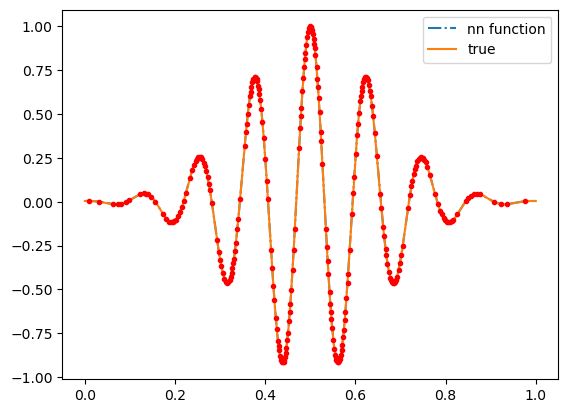

time taken:  4.9738852977752686
neuron num 		 error 		 order
4 		 1.534463 		 * 		 15.549642 		 * 

8 		 0.390252 		 1.975256 		 9.709167 		 0.679462 

16 		 0.132670 		 1.556565 		 7.130274 		 0.445390 

32 		 0.038147 		 1.798195 		 4.027780 		 0.823972 

64 		 0.008748 		 2.124575 		 2.253298 		 0.837947 

128 		 0.002894 		 1.595754 		 1.167985 		 0.948017 

256 		 0.000861 		 1.748791 		 0.621307 		 0.910644 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 1.534463 &		 * & 		 15.549642 & 		 *  \\ \hline  

8 		 &  3.903e-01 &  		 1.98 &  		 9.709e+00 &  		 0.68 \\ \hline  

16 		 &  1.327e-01 &  		 1.56 &  		 7.130e+00 &  		 0.45 \\ \hline  

32 		 &  3.815e-02 &  		 1.80 &  		 4.028e+00 &  		 0.82 \\ \hline  

64 		 &  8.748e-03 &  		 2.12 &  		 2.253e+00 &  		 0.84 \\ \hline  

128 		 &  2.894e-03 &  		 1.60 &  		 1.168e+00 &  		 0.95 \\ \hline  

256 		 &  8.612e-04 &  		 1.75 &  		 6.213e-01 &  		 0.91 \\ \hline  



In [64]:
# sigma = 0.15
# m = 8

import torch
import math

# Parameters for the Gabor function
sigma = 0.15
m = 8


def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term

def du_exact(x):
    """First derivative of the Gabor function with respect to each component for a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Derivative with respect to x_1
    du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)

    # Derivative with respect to other dimensions
    du_dx_other = exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term

    # Concatenate all the derivatives to keep dimension
    du_dx = torch.cat([du_dx1, du_dx_other], dim=1)

    return du_dx

def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term 
    - (2 * math.pi * m * exp_term * sin_term) 
    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * (((x[:, 1:] - 0.5) ** 2 / sigma ** 2) - 1) * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(x):
    return du_exact(x) 


function_name = "gabor1d" 
filename_write = "data/1DOGA-PBE-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 
relu_k = 1 
for N in [2**8]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**14
    order = 3
    exponent = 8
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGARandPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)



# # Example usage:
# # Define a batch of points as rows in a 2D tensor
# x_batch = torch.tensor([[0.5], [0.25], [0.1]])  # Example points in 2D

# gabor_vals = gabor_function(x_batch)
# gabor_derivs = gabor_derivative(x_batch)
# gabor_laplacians = gabor_laplacian(x_batch)
# rhs_vals = rhs(x_batch)

# print(f"Gabor Function Values: {gabor_vals}")
# print(f"Gabor Derivatives: {gabor_derivs}")
# print(f"Gabor Laplacians (summed): {gabor_laplacians}")
# print(f"Right-hand side values: {rhs_vals}")


# x_coord = torch.linspace(0,1,100).view(-1,1)
# print(gabor_function(x_coord).size())

# plt.plot(x_coord,gabor_function(x_coord) )
# plt.show()

using linear solver:  direct
epoch:  1
torch.Size([2, 256])
one output
argmax time:  0.0015571117401123047
selected neuron index:  tensor(177, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0023638, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:0.005991864110477727 	 residual l2 norm: 0.011500402950435362 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:1.463176248116079e-09 	 residual l2 norm: 2.808329471748472e-09 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:3.542949056912229e-16 	 residual l2 norm: 6.800116025829084e-16 
converged at iteration:  3
sol_update_l2_norm:3.542949056912229e-16 	 residual l2 norm: 6.800116025829084e-16 
epoch:  2
torch.Size([2, 256])
two outputs
argmax time:  0.0018088817596435547
selected neuron index:  tensor(177, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9835403, device='cuda:0')
newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:0.010154824317211708 	 residual l2 norm:

torch.Size([1, 18])
sol_update_l2_norm:10497.152272535866 	 residual l2 norm: 0.001373451065709355 
newton iteration:  2
torch.Size([1, 18])
sol_update_l2_norm:0.011793660109030496 	 residual l2 norm: 2.9026583380852052e-05 
newton iteration:  3
torch.Size([1, 18])
sol_update_l2_norm:3.5282867120533264e-08 	 residual l2 norm: 2.0134386767233464e-12 
converged at iteration:  3
sol_update_l2_norm:3.5282867120533264e-08 	 residual l2 norm: 2.0134386767233464e-12 
epoch:  19
torch.Size([2, 256])
two outputs
argmax time:  0.0017995834350585938
selected neuron index:  tensor(252, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7801754, device='cuda:0')
assembling the matrix time taken:  0.0001537799835205078
solving Ax = b time taken:  0.00019931793212890625
newton iteration:  1
torch.Size([1, 19])
sol_update_l2_norm:14854.909464922275 	 residual l2 norm: 0.0006192635655994028 
newton iteration:  2
torch.Size([1, 19])
sol_update_l2_norm:0.0260536227589867 	 residual l2 norm: 1.0534118

torch.Size([1, 36])
sol_update_l2_norm:4032.477843983994 	 residual l2 norm: 1.4731526682605967e-05 
newton iteration:  2
torch.Size([1, 36])
sol_update_l2_norm:0.00011325030582657396 	 residual l2 norm: 2.8924860022737363e-08 
newton iteration:  3
torch.Size([1, 36])
sol_update_l2_norm:6.588486023022535e-07 	 residual l2 norm: 1.4767074318197738e-12 
converged at iteration:  3
sol_update_l2_norm:6.588486023022535e-07 	 residual l2 norm: 1.4767074318197738e-12 
epoch:  37
torch.Size([2, 256])
two outputs
argmax time:  0.001773834228515625
selected neuron index:  tensor(75, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2383636, device='cuda:0')
assembling the matrix time taken:  0.0001544952392578125
solving Ax = b time taken:  0.000270843505859375
newton iteration:  1
torch.Size([1, 37])
sol_update_l2_norm:8344.866065463 	 residual l2 norm: 4.881485187647501e-06 
newton iteration:  2
torch.Size([1, 37])
sol_update_l2_norm:0.0015567150911504676 	 residual l2 norm: 3.41162409191

torch.Size([1, 43])
sol_update_l2_norm:9.642499734912354e-07 	 residual l2 norm: 1.942360727448367e-12 
newton iteration:  17
torch.Size([1, 43])
sol_update_l2_norm:7.634099683431986e-07 	 residual l2 norm: 2.4635266351232296e-12 
newton iteration:  18
torch.Size([1, 43])
sol_update_l2_norm:1.6166139806999597e-06 	 residual l2 norm: 2.9926166126828848e-12 
newton iteration:  19
torch.Size([1, 43])
sol_update_l2_norm:1.4162956246628756e-06 	 residual l2 norm: 3.2787803641114127e-13 
newton iteration:  20
torch.Size([1, 43])
sol_update_l2_norm:1.5928484252980142e-06 	 residual l2 norm: 2.487618252213281e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:1.5928484252980142e-06 	 residual l2 norm: 2.487618252213281e-12 
epoch:  44
torch.Size([2, 256])
two outputs
argmax time:  0.0017628669738769531
selected neuron index:  tensor(117, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7578339, device='cuda:0')
assembling the matrix time taken:  0.0001552104949951172
so

sol_update_l2_norm:9.94968322724896e-06 	 residual l2 norm: 2.6978698632357747e-12 
newton iteration:  6
torch.Size([1, 48])
sol_update_l2_norm:4.520095048123355e-06 	 residual l2 norm: 4.977178286450707e-13 
newton iteration:  7
torch.Size([1, 48])
sol_update_l2_norm:8.638484111856469e-06 	 residual l2 norm: 2.4646923665538566e-13 
newton iteration:  8
torch.Size([1, 48])
sol_update_l2_norm:3.4436846177819352e-06 	 residual l2 norm: 4.616003267161724e-13 
newton iteration:  9
torch.Size([1, 48])
sol_update_l2_norm:3.1964149196482856e-06 	 residual l2 norm: 1.5120705624131939e-12 
newton iteration:  10
torch.Size([1, 48])
sol_update_l2_norm:3.7374205743662938e-06 	 residual l2 norm: 1.6751093653985297e-12 
newton iteration:  11
torch.Size([1, 48])
sol_update_l2_norm:3.7262396741457415e-06 	 residual l2 norm: 1.6791711250783871e-12 
newton iteration:  12
torch.Size([1, 48])
sol_update_l2_norm:2.977195225968016e-06 	 residual l2 norm: 4.370931597981162e-12 
newton iteration:  13
torch.Si

torch.Size([1, 52])
sol_update_l2_norm:6.799685195916296e-06 	 residual l2 norm: 8.583756606068144e-13 
newton iteration:  15
torch.Size([1, 52])
sol_update_l2_norm:2.7922493027137676e-06 	 residual l2 norm: 1.287149924998933e-12 
newton iteration:  16
torch.Size([1, 52])
sol_update_l2_norm:9.451587683045494e-06 	 residual l2 norm: 2.077999007891796e-12 
newton iteration:  17
torch.Size([1, 52])
sol_update_l2_norm:6.2990606068228e-06 	 residual l2 norm: 1.0659454598848656e-12 
newton iteration:  18
torch.Size([1, 52])
sol_update_l2_norm:4.061631553520928e-06 	 residual l2 norm: 2.812334079068589e-12 
newton iteration:  19
torch.Size([1, 52])
sol_update_l2_norm:6.901281712156648e-06 	 residual l2 norm: 8.848149605883439e-13 
newton iteration:  20
torch.Size([1, 52])
sol_update_l2_norm:6.317481973325025e-06 	 residual l2 norm: 9.962154478657837e-13 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:6.317481973325025e-06 	 residual l2 norm: 9.962154478657837e-13 
epoch:  53


newton iteration:  1
torch.Size([1, 57])
sol_update_l2_norm:1802.437450144523 	 residual l2 norm: 4.754249444293091e-05 
newton iteration:  2
torch.Size([1, 57])
sol_update_l2_norm:0.004110743407898137 	 residual l2 norm: 9.95638212957156e-11 
newton iteration:  3
torch.Size([1, 57])
sol_update_l2_norm:9.344174378527147e-06 	 residual l2 norm: 1.650893626524838e-12 
newton iteration:  4
torch.Size([1, 57])
sol_update_l2_norm:7.0823111819996934e-06 	 residual l2 norm: 1.6705220500737903e-12 
newton iteration:  5
torch.Size([1, 57])
sol_update_l2_norm:8.80063197490016e-06 	 residual l2 norm: 1.5619103607600829e-12 
newton iteration:  6
torch.Size([1, 57])
sol_update_l2_norm:9.611628912683796e-06 	 residual l2 norm: 1.504241659934514e-12 
newton iteration:  7
torch.Size([1, 57])
sol_update_l2_norm:1.1990814716805357e-05 	 residual l2 norm: 4.472146043786083e-12 
newton iteration:  8
torch.Size([1, 57])
sol_update_l2_norm:1.1744396922444553e-05 	 residual l2 norm: 3.0999473993768265e-12 
n

torch.Size([1, 61])
sol_update_l2_norm:1.841095699538687e-05 	 residual l2 norm: 1.825480558661664e-12 
newton iteration:  10
torch.Size([1, 61])
sol_update_l2_norm:1.470558356069529e-05 	 residual l2 norm: 1.9998866739961262e-12 
newton iteration:  11
torch.Size([1, 61])
sol_update_l2_norm:9.942893450337659e-06 	 residual l2 norm: 1.8773155979661234e-12 
newton iteration:  12
torch.Size([1, 61])
sol_update_l2_norm:1.122441984464236e-05 	 residual l2 norm: 1.522219927202906e-12 
newton iteration:  13
torch.Size([1, 61])
sol_update_l2_norm:9.52994600302755e-06 	 residual l2 norm: 5.982200340902649e-13 
newton iteration:  14
torch.Size([1, 61])
sol_update_l2_norm:7.588846609250064e-06 	 residual l2 norm: 1.2060786167374381e-12 
newton iteration:  15
torch.Size([1, 61])
sol_update_l2_norm:7.920415379360584e-06 	 residual l2 norm: 2.3180746682173976e-12 
newton iteration:  16
torch.Size([1, 61])
sol_update_l2_norm:9.037785736411577e-06 	 residual l2 norm: 2.009950301059767e-12 
newton iter

torch.Size([1, 65])
sol_update_l2_norm:1.392045102562602e-05 	 residual l2 norm: 1.7379509731551126e-12 
newton iteration:  19
torch.Size([1, 65])
sol_update_l2_norm:1.3298005543638316e-05 	 residual l2 norm: 1.5291857288942706e-13 
newton iteration:  20
torch.Size([1, 65])
sol_update_l2_norm:1.964737080854525e-05 	 residual l2 norm: 1.5552413198842037e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:1.964737080854525e-05 	 residual l2 norm: 1.5552413198842037e-12 
epoch:  66
torch.Size([2, 256])
two outputs
argmax time:  0.0017704963684082031
selected neuron index:  tensor(229, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0269788, device='cuda:0')
assembling the matrix time taken:  0.00015735626220703125
solving Ax = b time taken:  0.0003542900085449219
newton iteration:  1
torch.Size([1, 66])
sol_update_l2_norm:491.2979092956506 	 residual l2 norm: 1.2131425269113577e-05 
newton iteration:  2
torch.Size([1, 66])
sol_update_l2_norm:0.005965906788546253 	 

torch.Size([1, 70])
sol_update_l2_norm:0.014066790024741434 	 residual l2 norm: 4.5510393494532515e-11 
newton iteration:  3
torch.Size([1, 70])
sol_update_l2_norm:2.9841758798847582e-05 	 residual l2 norm: 1.5498774334900895e-12 
newton iteration:  4
torch.Size([1, 70])
sol_update_l2_norm:3.9687888259422655e-05 	 residual l2 norm: 3.107559711421853e-12 
newton iteration:  5
torch.Size([1, 70])
sol_update_l2_norm:2.050072038149686e-05 	 residual l2 norm: 9.985599548017226e-13 
newton iteration:  6
torch.Size([1, 70])
sol_update_l2_norm:3.939021086429534e-05 	 residual l2 norm: 3.657150660753737e-12 
newton iteration:  7
torch.Size([1, 70])
sol_update_l2_norm:5.193413837464659e-05 	 residual l2 norm: 1.889641692742776e-12 
newton iteration:  8
torch.Size([1, 70])
sol_update_l2_norm:3.22674736975757e-05 	 residual l2 norm: 2.802764282565663e-12 
newton iteration:  9
torch.Size([1, 70])
sol_update_l2_norm:3.5182327746969493e-05 	 residual l2 norm: 3.2942702880088853e-12 
newton iteration:

torch.Size([1, 74])
sol_update_l2_norm:4.695942733534446e-05 	 residual l2 norm: 1.4538493788105759e-12 
newton iteration:  10
torch.Size([1, 74])
sol_update_l2_norm:5.513563508760332e-05 	 residual l2 norm: 1.838969515467792e-12 
newton iteration:  11
torch.Size([1, 74])
sol_update_l2_norm:3.8968295616818226e-05 	 residual l2 norm: 2.5337710893369022e-12 
newton iteration:  12
torch.Size([1, 74])
sol_update_l2_norm:4.913946876664376e-05 	 residual l2 norm: 3.1522430431010944e-12 
newton iteration:  13
torch.Size([1, 74])
sol_update_l2_norm:4.232530391489653e-05 	 residual l2 norm: 2.806048696448073e-12 
newton iteration:  14
torch.Size([1, 74])
sol_update_l2_norm:4.653968863476589e-05 	 residual l2 norm: 2.859686681661208e-12 
newton iteration:  15
torch.Size([1, 74])
sol_update_l2_norm:5.1612112291692254e-05 	 residual l2 norm: 3.209863610970704e-12 
newton iteration:  16
torch.Size([1, 74])
sol_update_l2_norm:5.364231938880185e-05 	 residual l2 norm: 1.3838486969989718e-12 
newton i

torch.Size([1, 78])
sol_update_l2_norm:4.454598333685168e-05 	 residual l2 norm: 4.488376483139029e-12 
newton iteration:  15
torch.Size([1, 78])
sol_update_l2_norm:3.943875979360255e-05 	 residual l2 norm: 2.855104601810409e-12 
newton iteration:  16
torch.Size([1, 78])
sol_update_l2_norm:4.2807828259696904e-05 	 residual l2 norm: 2.355848943966921e-12 
newton iteration:  17
torch.Size([1, 78])
sol_update_l2_norm:6.128463893682535e-05 	 residual l2 norm: 1.7282030216918876e-12 
newton iteration:  18
torch.Size([1, 78])
sol_update_l2_norm:5.083929244510155e-05 	 residual l2 norm: 1.1592546220058962e-12 
newton iteration:  19
torch.Size([1, 78])
sol_update_l2_norm:3.61879922241526e-05 	 residual l2 norm: 1.5381684018445944e-12 
newton iteration:  20
torch.Size([1, 78])
sol_update_l2_norm:5.000828793241068e-05 	 residual l2 norm: 4.242996211331871e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:5.000828793241068e-05 	 residual l2 norm: 4.242996211331871e-12 
epoch:  

torch.Size([1, 82])
sol_update_l2_norm:0.00010766706700616773 	 residual l2 norm: 2.774121815972964e-12 
newton iteration:  20
torch.Size([1, 82])
sol_update_l2_norm:7.88916553306932e-05 	 residual l2 norm: 3.3026926710304934e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:7.88916553306932e-05 	 residual l2 norm: 3.3026926710304934e-12 
epoch:  83
torch.Size([2, 256])
two outputs
argmax time:  0.001744985580444336
selected neuron index:  tensor(166, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1709499, device='cuda:0')
assembling the matrix time taken:  0.00015306472778320312
solving Ax = b time taken:  0.0004189014434814453
newton iteration:  1
torch.Size([1, 83])
sol_update_l2_norm:1271.0510781852688 	 residual l2 norm: 0.00011205119445307785 
newton iteration:  2
torch.Size([1, 83])
sol_update_l2_norm:0.04269121452061302 	 residual l2 norm: 1.43997173012974e-11 
newton iteration:  3
torch.Size([1, 83])
sol_update_l2_norm:7.38323517341833e-05 	 residual

assembling the matrix time taken:  0.00015878677368164062
solving Ax = b time taken:  0.0004951953887939453
newton iteration:  1
torch.Size([1, 87])
sol_update_l2_norm:1427.962721635419 	 residual l2 norm: 0.0001307647998631842 
newton iteration:  2
torch.Size([1, 87])
sol_update_l2_norm:0.062070414454440156 	 residual l2 norm: 4.9137851608297505e-12 
newton iteration:  3
torch.Size([1, 87])
sol_update_l2_norm:8.82173175724617e-05 	 residual l2 norm: 3.935775962747219e-12 
newton iteration:  4
torch.Size([1, 87])
sol_update_l2_norm:7.825474714688443e-05 	 residual l2 norm: 2.2466382717117386e-12 
newton iteration:  5
torch.Size([1, 87])
sol_update_l2_norm:8.573888229627247e-05 	 residual l2 norm: 1.1742772138529524e-12 
newton iteration:  6
torch.Size([1, 87])
sol_update_l2_norm:0.00010985797813257686 	 residual l2 norm: 1.8601629662951698e-12 
newton iteration:  7
torch.Size([1, 87])
sol_update_l2_norm:0.00013648410284318493 	 residual l2 norm: 2.020329088847316e-12 
newton iteration:

torch.Size([1, 91])
sol_update_l2_norm:6904.605454946304 	 residual l2 norm: 0.00035358710976397665 
newton iteration:  2
torch.Size([1, 91])
sol_update_l2_norm:0.3097004951438635 	 residual l2 norm: 3.3967766784198934e-11 
newton iteration:  3
torch.Size([1, 91])
sol_update_l2_norm:0.00013576997314250565 	 residual l2 norm: 1.444523010072109e-12 
newton iteration:  4
torch.Size([1, 91])
sol_update_l2_norm:0.0001480080582992884 	 residual l2 norm: 4.151831024312439e-12 
newton iteration:  5
torch.Size([1, 91])
sol_update_l2_norm:0.00010809608694784658 	 residual l2 norm: 4.064419001761805e-12 
newton iteration:  6
torch.Size([1, 91])
sol_update_l2_norm:0.00012866964287280822 	 residual l2 norm: 1.8537832985568482e-12 
newton iteration:  7
torch.Size([1, 91])
sol_update_l2_norm:0.00014808532635415277 	 residual l2 norm: 2.090549457257872e-12 
newton iteration:  8
torch.Size([1, 91])
sol_update_l2_norm:0.00019745247495647522 	 residual l2 norm: 1.781093566870081e-12 
newton iteration:  9

torch.Size([1, 95])
sol_update_l2_norm:0.3246894663549054 	 residual l2 norm: 3.262757509778258e-11 
newton iteration:  3
torch.Size([1, 95])
sol_update_l2_norm:0.00029480364710023614 	 residual l2 norm: 8.223249108615888e-13 
newton iteration:  4
torch.Size([1, 95])
sol_update_l2_norm:0.00018287476958775393 	 residual l2 norm: 2.4516357710674014e-12 
newton iteration:  5
torch.Size([1, 95])
sol_update_l2_norm:0.0001580563287680027 	 residual l2 norm: 5.628771253061993e-13 
newton iteration:  6
torch.Size([1, 95])
sol_update_l2_norm:0.00013743322303043747 	 residual l2 norm: 2.2380563920876113e-12 
newton iteration:  7
torch.Size([1, 95])
sol_update_l2_norm:0.0001333764152194152 	 residual l2 norm: 5.413073591086629e-13 
newton iteration:  8
torch.Size([1, 95])
sol_update_l2_norm:0.0001742832712284261 	 residual l2 norm: 6.665560865958053e-13 
newton iteration:  9
torch.Size([1, 95])
sol_update_l2_norm:0.00018788944392762776 	 residual l2 norm: 5.628364918947546e-12 
newton iteration: 

torch.Size([1, 99])
sol_update_l2_norm:0.19677335947492755 	 residual l2 norm: 1.7201020671623028e-12 
newton iteration:  3
torch.Size([1, 99])
sol_update_l2_norm:0.00022393995689298733 	 residual l2 norm: 1.8284769890477823e-12 
newton iteration:  4
torch.Size([1, 99])
sol_update_l2_norm:0.00021193352140747054 	 residual l2 norm: 3.901851350758281e-13 
newton iteration:  5
torch.Size([1, 99])
sol_update_l2_norm:0.0002301116963255494 	 residual l2 norm: 1.4741125450003725e-12 
newton iteration:  6
torch.Size([1, 99])
sol_update_l2_norm:0.00025702347534297407 	 residual l2 norm: 4.567508181700857e-13 
newton iteration:  7
torch.Size([1, 99])
sol_update_l2_norm:0.00016117772662252005 	 residual l2 norm: 2.3315175399297036e-12 
newton iteration:  8
torch.Size([1, 99])
sol_update_l2_norm:0.00021660786173687 	 residual l2 norm: 2.546613006019553e-12 
newton iteration:  9
torch.Size([1, 99])
sol_update_l2_norm:0.00020385516083841503 	 residual l2 norm: 2.3826725190899676e-12 
newton iteratio

newton iteration:  1
torch.Size([1, 103])
sol_update_l2_norm:7716.943214561604 	 residual l2 norm: 0.0007588169732980096 
newton iteration:  2
torch.Size([1, 103])
sol_update_l2_norm:0.3945657032128115 	 residual l2 norm: 2.30777558190153e-11 
newton iteration:  3
torch.Size([1, 103])
sol_update_l2_norm:0.00022571523494111144 	 residual l2 norm: 7.635663585025291e-13 
newton iteration:  4
torch.Size([1, 103])
sol_update_l2_norm:0.00019564686218515235 	 residual l2 norm: 1.628635159961245e-12 
newton iteration:  5
torch.Size([1, 103])
sol_update_l2_norm:0.00021250987935680143 	 residual l2 norm: 2.1707051745717056e-12 
newton iteration:  6
torch.Size([1, 103])
sol_update_l2_norm:0.0002584977648244164 	 residual l2 norm: 2.809595151441918e-12 
newton iteration:  7
torch.Size([1, 103])
sol_update_l2_norm:0.00027870500445796023 	 residual l2 norm: 4.615644218356806e-12 
newton iteration:  8
torch.Size([1, 103])
sol_update_l2_norm:0.00027196724229788425 	 residual l2 norm: 1.812060419852733

torch.Size([1, 106])
sol_update_l2_norm:0.000208787302390584 	 residual l2 norm: 1.304197045773755e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.000208787302390584 	 residual l2 norm: 1.304197045773755e-12 
epoch:  107
torch.Size([2, 256])
two outputs
argmax time:  0.0017921924591064453
selected neuron index:  tensor(123, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6795042, device='cuda:0')
assembling the matrix time taken:  0.00016498565673828125
solving Ax = b time taken:  0.0005259513854980469
newton iteration:  1
torch.Size([1, 107])
sol_update_l2_norm:39762.13161111777 	 residual l2 norm: 0.001431734050916283 
newton iteration:  2
torch.Size([1, 107])
sol_update_l2_norm:5.531780554110333 	 residual l2 norm: 1.9471386763934838e-10 
newton iteration:  3
torch.Size([1, 107])
sol_update_l2_norm:0.0016116133384965793 	 residual l2 norm: 8.652110122783455e-13 
newton iteration:  4
torch.Size([1, 107])
sol_update_l2_norm:0.00033375100909079216 	 residu

torch.Size([1, 110])
sol_update_l2_norm:0.0005009909673309266 	 residual l2 norm: 2.765109574115915e-12 
newton iteration:  18
torch.Size([1, 110])
sol_update_l2_norm:0.0003438404483375115 	 residual l2 norm: 2.1646244554349642e-12 
newton iteration:  19
torch.Size([1, 110])
sol_update_l2_norm:0.0005118720569931833 	 residual l2 norm: 1.3989422514370478e-12 
newton iteration:  20
torch.Size([1, 110])
sol_update_l2_norm:0.00046919388946523483 	 residual l2 norm: 1.3755188314860095e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.00046919388946523483 	 residual l2 norm: 1.3755188314860095e-12 
epoch:  111
torch.Size([2, 256])
two outputs
argmax time:  0.0017726421356201172
selected neuron index:  tensor(143, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2035066, device='cuda:0')
assembling the matrix time taken:  0.0001614093780517578
solving Ax = b time taken:  0.0005474090576171875
newton iteration:  1
torch.Size([1, 111])
sol_update_l2_norm:284369.913965

torch.Size([1, 114])
sol_update_l2_norm:0.00043336370858236106 	 residual l2 norm: 1.0266192058862595e-12 
newton iteration:  15
torch.Size([1, 114])
sol_update_l2_norm:0.00047709084940053553 	 residual l2 norm: 9.588632498698389e-13 
newton iteration:  16
torch.Size([1, 114])
sol_update_l2_norm:0.0005751675065509815 	 residual l2 norm: 2.353010136091919e-12 
newton iteration:  17
torch.Size([1, 114])
sol_update_l2_norm:0.0007976775588571379 	 residual l2 norm: 2.2901654498159013e-12 
newton iteration:  18
torch.Size([1, 114])
sol_update_l2_norm:0.0005603523157003831 	 residual l2 norm: 7.490649272992519e-13 
newton iteration:  19
torch.Size([1, 114])
sol_update_l2_norm:0.0005609323780722194 	 residual l2 norm: 7.840385227686074e-13 
newton iteration:  20
torch.Size([1, 114])
sol_update_l2_norm:0.0007158044467728555 	 residual l2 norm: 1.3102047709469725e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.0007158044467728555 	 residual l2 norm: 1.3102047709469725e-12

torch.Size([1, 118])
sol_update_l2_norm:0.00032861913461723364 	 residual l2 norm: 7.446715766409554e-13 
newton iteration:  12
torch.Size([1, 118])
sol_update_l2_norm:0.0005598221566464786 	 residual l2 norm: 9.043952166444436e-13 
newton iteration:  13
torch.Size([1, 118])
sol_update_l2_norm:0.0005607864847325128 	 residual l2 norm: 1.103534343311504e-12 
newton iteration:  14
torch.Size([1, 118])
sol_update_l2_norm:0.0005544959747088797 	 residual l2 norm: 1.6843336509833271e-12 
newton iteration:  15
torch.Size([1, 118])
sol_update_l2_norm:0.0010052873793346259 	 residual l2 norm: 3.792722011570613e-12 
newton iteration:  16
torch.Size([1, 118])
sol_update_l2_norm:0.0008902055116982663 	 residual l2 norm: 2.589464091697362e-12 
newton iteration:  17
torch.Size([1, 118])
sol_update_l2_norm:0.0005622401216761517 	 residual l2 norm: 1.6784381786420977e-12 
newton iteration:  18
torch.Size([1, 118])
sol_update_l2_norm:0.0005800241951299605 	 residual l2 norm: 3.3865677928087875e-12 
ne

torch.Size([1, 122])
sol_update_l2_norm:0.0003799284677119901 	 residual l2 norm: 1.2296271569762725e-12 
newton iteration:  8
torch.Size([1, 122])
sol_update_l2_norm:0.0003953384491516096 	 residual l2 norm: 2.0830283240870863e-12 
newton iteration:  9
torch.Size([1, 122])
sol_update_l2_norm:0.0003921425809135606 	 residual l2 norm: 1.1922060227101126e-12 
newton iteration:  10
torch.Size([1, 122])
sol_update_l2_norm:0.0005068462332313739 	 residual l2 norm: 2.6226281586270574e-12 
newton iteration:  11
torch.Size([1, 122])
sol_update_l2_norm:0.0005273085234123374 	 residual l2 norm: 1.4102688464360785e-12 
newton iteration:  12
torch.Size([1, 122])
sol_update_l2_norm:0.0003102530671009813 	 residual l2 norm: 1.5972989029428043e-12 
newton iteration:  13
torch.Size([1, 122])
sol_update_l2_norm:0.0003658474911673883 	 residual l2 norm: 1.5664413489035728e-12 
newton iteration:  14
torch.Size([1, 122])
sol_update_l2_norm:0.000384733025871442 	 residual l2 norm: 3.483257973797757e-12 
ne

torch.Size([1, 126])
sol_update_l2_norm:0.002078449162394125 	 residual l2 norm: 3.2744124669880318e-12 
newton iteration:  4
torch.Size([1, 126])
sol_update_l2_norm:0.0007507445145648646 	 residual l2 norm: 2.248616718635415e-12 
newton iteration:  5
torch.Size([1, 126])
sol_update_l2_norm:0.0004416551739473823 	 residual l2 norm: 2.109355369461741e-12 
newton iteration:  6
torch.Size([1, 126])
sol_update_l2_norm:0.0004767473272902984 	 residual l2 norm: 1.3605404794354368e-12 
newton iteration:  7
torch.Size([1, 126])
sol_update_l2_norm:0.00044360263672363104 	 residual l2 norm: 2.9784079184302764e-12 
newton iteration:  8
torch.Size([1, 126])
sol_update_l2_norm:0.0005924764005160837 	 residual l2 norm: 2.3148613573815143e-12 
newton iteration:  9
torch.Size([1, 126])
sol_update_l2_norm:0.0006446671827100115 	 residual l2 norm: 1.7424502090725008e-12 
newton iteration:  10
torch.Size([1, 126])
sol_update_l2_norm:0.0005556796023694239 	 residual l2 norm: 9.810097070502172e-13 
newton 

two outputs
argmax time:  0.0019521713256835938
selected neuron index:  tensor(181, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3494980, device='cuda:0')
assembling the matrix time taken:  0.000152587890625
solving Ax = b time taken:  0.0007586479187011719
newton iteration:  1
torch.Size([1, 130])
sol_update_l2_norm:29337.536277511044 	 residual l2 norm: 0.0014969399555304543 
newton iteration:  2
torch.Size([1, 130])
sol_update_l2_norm:13.305820314674506 	 residual l2 norm: 2.452655091098646e-10 
newton iteration:  3
torch.Size([1, 130])
sol_update_l2_norm:0.006222195951715465 	 residual l2 norm: 1.827116024285279e-12 
newton iteration:  4
torch.Size([1, 130])
sol_update_l2_norm:0.0008121412124528357 	 residual l2 norm: 7.14702569488733e-13 
newton iteration:  5
torch.Size([1, 130])
sol_update_l2_norm:0.0005117338312217244 	 residual l2 norm: 5.757925078659089e-12 
newton iteration:  6
torch.Size([1, 130])
sol_update_l2_norm:0.0006478288221071603 	 residual l2 norm: 2.49149

torch.Size([1, 133])
sol_update_l2_norm:0.001133786369902076 	 residual l2 norm: 1.0352695499773962e-12 
newton iteration:  15
torch.Size([1, 133])
sol_update_l2_norm:0.001209270580394098 	 residual l2 norm: 5.678525071300448e-13 
newton iteration:  16
torch.Size([1, 133])
sol_update_l2_norm:0.0010296166916367966 	 residual l2 norm: 1.5248323381207399e-12 
newton iteration:  17
torch.Size([1, 133])
sol_update_l2_norm:0.0014434251417231277 	 residual l2 norm: 7.465301194356603e-13 
newton iteration:  18
torch.Size([1, 133])
sol_update_l2_norm:0.0009959703169845275 	 residual l2 norm: 8.713425700855933e-13 
newton iteration:  19
torch.Size([1, 133])
sol_update_l2_norm:0.0013869041240368908 	 residual l2 norm: 1.927088208581595e-12 
newton iteration:  20
torch.Size([1, 133])
sol_update_l2_norm:0.0008368407597318888 	 residual l2 norm: 4.750740269902547e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.0008368407597318888 	 residual l2 norm: 4.750740269902547e-12 
epoc

torch.Size([1, 137])
sol_update_l2_norm:0.002196288680018379 	 residual l2 norm: 2.4231237163561157e-12 
newton iteration:  7
torch.Size([1, 137])
sol_update_l2_norm:0.0012518133083149737 	 residual l2 norm: 1.3642304728709342e-12 
newton iteration:  8
torch.Size([1, 137])
sol_update_l2_norm:0.0009768029303628268 	 residual l2 norm: 8.41715818844289e-13 
newton iteration:  9
torch.Size([1, 137])
sol_update_l2_norm:0.0020380933199928525 	 residual l2 norm: 7.117517891567617e-13 
newton iteration:  10
torch.Size([1, 137])
sol_update_l2_norm:0.0017054192428972983 	 residual l2 norm: 1.9596881453214623e-12 
newton iteration:  11
torch.Size([1, 137])
sol_update_l2_norm:0.0010601968437720655 	 residual l2 norm: 1.7502666390127468e-12 
newton iteration:  12
torch.Size([1, 137])
sol_update_l2_norm:0.0028907327110665286 	 residual l2 norm: 2.1753839982339778e-13 
newton iteration:  13
torch.Size([1, 137])
sol_update_l2_norm:0.001555425812356465 	 residual l2 norm: 3.9691741809941766e-12 
newton

torch.Size([1, 140])
sol_update_l2_norm:0.0016276543144194621 	 residual l2 norm: 1.7515300406312362e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.0016276543144194621 	 residual l2 norm: 1.7515300406312362e-12 
epoch:  141
torch.Size([2, 256])
two outputs
argmax time:  0.0017819404602050781
selected neuron index:  tensor(140, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4951937, device='cuda:0')
assembling the matrix time taken:  0.00015687942504882812
solving Ax = b time taken:  0.0008087158203125
newton iteration:  1
torch.Size([1, 141])
sol_update_l2_norm:43643.036939887046 	 residual l2 norm: 0.00014737151200084372 
newton iteration:  2
torch.Size([1, 141])
sol_update_l2_norm:12.855471130180051 	 residual l2 norm: 7.992701485841394e-11 
newton iteration:  3
torch.Size([1, 141])
sol_update_l2_norm:0.014997202857966603 	 residual l2 norm: 1.844510018641651e-12 
newton iteration:  4
torch.Size([1, 141])
sol_update_l2_norm:0.0015161604488768158 	 resi

torch.Size([1, 144])
sol_update_l2_norm:0.0013103281601482269 	 residual l2 norm: 2.6157266696250287e-12 
newton iteration:  10
torch.Size([1, 144])
sol_update_l2_norm:0.0014808534850910945 	 residual l2 norm: 2.509068709949712e-12 
newton iteration:  11
torch.Size([1, 144])
sol_update_l2_norm:0.002019673178630327 	 residual l2 norm: 4.1171125633258734e-13 
newton iteration:  12
torch.Size([1, 144])
sol_update_l2_norm:0.0024795352995253574 	 residual l2 norm: 1.8891231790931346e-12 
newton iteration:  13
torch.Size([1, 144])
sol_update_l2_norm:0.0025146990144868 	 residual l2 norm: 2.1936743244626112e-12 
newton iteration:  14
torch.Size([1, 144])
sol_update_l2_norm:0.0016960181218452078 	 residual l2 norm: 2.472309711890942e-12 
newton iteration:  15
torch.Size([1, 144])
sol_update_l2_norm:0.003450762258329042 	 residual l2 norm: 2.263480102990987e-12 
newton iteration:  16
torch.Size([1, 144])
sol_update_l2_norm:0.002985152094229367 	 residual l2 norm: 1.934159221241719e-12 
newton i

torch.Size([1, 147])
sol_update_l2_norm:0.006556939259876077 	 residual l2 norm: 2.832175095868471e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.006556939259876077 	 residual l2 norm: 2.832175095868471e-12 
epoch:  148
torch.Size([2, 256])
two outputs
argmax time:  0.0017902851104736328
selected neuron index:  tensor(191, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1280772, device='cuda:0')
assembling the matrix time taken:  0.00014781951904296875
solving Ax = b time taken:  0.0008602142333984375
newton iteration:  1
torch.Size([1, 148])
sol_update_l2_norm:489830.98092027503 	 residual l2 norm: 0.003840663061633742 
newton iteration:  2
torch.Size([1, 148])
sol_update_l2_norm:365.51087449690635 	 residual l2 norm: 6.306656710146475e-08 
newton iteration:  3
torch.Size([1, 148])
sol_update_l2_norm:0.3785138395615595 	 residual l2 norm: 1.1730379199564732e-12 
newton iteration:  4
torch.Size([1, 148])
sol_update_l2_norm:0.008400715285772922 	 residual 

torch.Size([1, 151])
sol_update_l2_norm:0.008829548587791551 	 residual l2 norm: 8.665236253468222e-13 
newton iteration:  7
torch.Size([1, 151])
sol_update_l2_norm:0.012814569642786966 	 residual l2 norm: 2.1143228789067743e-12 
newton iteration:  8
torch.Size([1, 151])
sol_update_l2_norm:0.00898017738251268 	 residual l2 norm: 2.2136279046174507e-12 
newton iteration:  9
torch.Size([1, 151])
sol_update_l2_norm:0.007462499338124594 	 residual l2 norm: 2.1565079645398727e-12 
newton iteration:  10
torch.Size([1, 151])
sol_update_l2_norm:0.00991454440833866 	 residual l2 norm: 8.682566197889103e-13 
newton iteration:  11
torch.Size([1, 151])
sol_update_l2_norm:0.007100287098718188 	 residual l2 norm: 2.3393102606258363e-12 
newton iteration:  12
torch.Size([1, 151])
sol_update_l2_norm:0.006597650855752976 	 residual l2 norm: 2.73838519909416e-12 
newton iteration:  13
torch.Size([1, 151])
sol_update_l2_norm:0.008587582666563431 	 residual l2 norm: 1.6548324336399287e-12 
newton iteratio

torch.Size([1, 154])
sol_update_l2_norm:0.004268984340082418 	 residual l2 norm: 1.7495399749069088e-13 
newton iteration:  15
torch.Size([1, 154])
sol_update_l2_norm:0.004543194680992256 	 residual l2 norm: 1.5509763514424667e-12 
newton iteration:  16
torch.Size([1, 154])
sol_update_l2_norm:0.004312239518502299 	 residual l2 norm: 1.0706059998686458e-12 
newton iteration:  17
torch.Size([1, 154])
sol_update_l2_norm:0.0045325443191379785 	 residual l2 norm: 1.4328092874692578e-12 
newton iteration:  18
torch.Size([1, 154])
sol_update_l2_norm:0.0037058302598000836 	 residual l2 norm: 9.631007482383038e-13 
newton iteration:  19
torch.Size([1, 154])
sol_update_l2_norm:0.0037766235885666626 	 residual l2 norm: 1.2399300092129237e-12 
newton iteration:  20
torch.Size([1, 154])
sol_update_l2_norm:0.004689202957358231 	 residual l2 norm: 1.942280075276539e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.004689202957358231 	 residual l2 norm: 1.942280075276539e-12 
epoc

epoch:  158
torch.Size([2, 256])
two outputs
argmax time:  0.0019216537475585938
selected neuron index:  tensor(210, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5037713, device='cuda:0')
assembling the matrix time taken:  0.0001468658447265625
solving Ax = b time taken:  0.0009121894836425781
newton iteration:  1
torch.Size([1, 158])
sol_update_l2_norm:78210.7649460192 	 residual l2 norm: 0.004207420265133575 
newton iteration:  2
torch.Size([1, 158])
sol_update_l2_norm:84.15914704295676 	 residual l2 norm: 1.1766370525370656e-09 
newton iteration:  3
torch.Size([1, 158])
sol_update_l2_norm:0.11848668649485607 	 residual l2 norm: 2.871473238836451e-12 
newton iteration:  4
torch.Size([1, 158])
sol_update_l2_norm:0.004269839826301802 	 residual l2 norm: 2.404931093083129e-12 
newton iteration:  5
torch.Size([1, 158])
sol_update_l2_norm:0.004457676277410252 	 residual l2 norm: 1.2675507075698141e-12 
newton iteration:  6
torch.Size([1, 158])
sol_update_l2_norm:0.00477048329584

torch.Size([1, 161])
sol_update_l2_norm:0.006010504123442152 	 residual l2 norm: 2.520019175296604e-12 
newton iteration:  5
torch.Size([1, 161])
sol_update_l2_norm:0.008339056857454905 	 residual l2 norm: 3.7236757152541897e-13 
newton iteration:  6
torch.Size([1, 161])
sol_update_l2_norm:0.008394985234289139 	 residual l2 norm: 1.3061153307727854e-13 
newton iteration:  7
torch.Size([1, 161])
sol_update_l2_norm:0.006845143469391558 	 residual l2 norm: 1.1006667056370058e-12 
newton iteration:  8
torch.Size([1, 161])
sol_update_l2_norm:0.007399049002801814 	 residual l2 norm: 1.8153082555746305e-12 
newton iteration:  9
torch.Size([1, 161])
sol_update_l2_norm:0.006541325224002491 	 residual l2 norm: 2.242950005229259e-12 
newton iteration:  10
torch.Size([1, 161])
sol_update_l2_norm:0.007241325604217979 	 residual l2 norm: 1.572638598928472e-12 
newton iteration:  11
torch.Size([1, 161])
sol_update_l2_norm:0.005210324094786049 	 residual l2 norm: 4.164768925447528e-13 
newton iteratio

torch.Size([1, 164])
sol_update_l2_norm:0.010356299015411406 	 residual l2 norm: 2.3642839481383326e-12 
newton iteration:  9
torch.Size([1, 164])
sol_update_l2_norm:0.013227246548908486 	 residual l2 norm: 1.4583018138701435e-12 
newton iteration:  10
torch.Size([1, 164])
sol_update_l2_norm:0.009112252125500988 	 residual l2 norm: 1.568712086914425e-12 
newton iteration:  11
torch.Size([1, 164])
sol_update_l2_norm:0.010467300410727036 	 residual l2 norm: 1.6557244938451895e-12 
newton iteration:  12
torch.Size([1, 164])
sol_update_l2_norm:0.011015863294197396 	 residual l2 norm: 1.0844366170980347e-12 
newton iteration:  13
torch.Size([1, 164])
sol_update_l2_norm:0.010170675048169552 	 residual l2 norm: 2.5749007999418315e-12 
newton iteration:  14
torch.Size([1, 164])
sol_update_l2_norm:0.009274703261542633 	 residual l2 norm: 9.120737408852925e-13 
newton iteration:  15
torch.Size([1, 164])
sol_update_l2_norm:0.00597204118684092 	 residual l2 norm: 3.86403051487875e-12 
newton itera

torch.Size([1, 167])
sol_update_l2_norm:0.00882971590114017 	 residual l2 norm: 1.7010323713881825e-12 
newton iteration:  12
torch.Size([1, 167])
sol_update_l2_norm:0.014710120631739456 	 residual l2 norm: 2.217310517150354e-12 
newton iteration:  13
torch.Size([1, 167])
sol_update_l2_norm:0.013886664051648482 	 residual l2 norm: 3.1142571654636893e-12 
newton iteration:  14
torch.Size([1, 167])
sol_update_l2_norm:0.010150961128190444 	 residual l2 norm: 6.040318019242302e-13 
newton iteration:  15
torch.Size([1, 167])
sol_update_l2_norm:0.01212530338425355 	 residual l2 norm: 3.179594125288538e-13 
newton iteration:  16
torch.Size([1, 167])
sol_update_l2_norm:0.011500385997838461 	 residual l2 norm: 2.705381993928532e-12 
newton iteration:  17
torch.Size([1, 167])
sol_update_l2_norm:0.009510569563796126 	 residual l2 norm: 1.755575668079912e-12 
newton iteration:  18
torch.Size([1, 167])
sol_update_l2_norm:0.011152179970047449 	 residual l2 norm: 1.0535350254149407e-12 
newton iterat

torch.Size([1, 170])
sol_update_l2_norm:0.008975604385537947 	 residual l2 norm: 2.8624556991279467e-12 
newton iteration:  14
torch.Size([1, 170])
sol_update_l2_norm:0.008267717634493275 	 residual l2 norm: 2.722885114877663e-12 
newton iteration:  15
torch.Size([1, 170])
sol_update_l2_norm:0.007120387652760526 	 residual l2 norm: 1.6258890787162825e-12 
newton iteration:  16
torch.Size([1, 170])
sol_update_l2_norm:0.007101483356570371 	 residual l2 norm: 4.711905517123519e-13 
newton iteration:  17
torch.Size([1, 170])
sol_update_l2_norm:0.006506042653159561 	 residual l2 norm: 5.866381402200618e-13 
newton iteration:  18
torch.Size([1, 170])
sol_update_l2_norm:0.00814313848701157 	 residual l2 norm: 1.845260893862179e-12 
newton iteration:  19
torch.Size([1, 170])
sol_update_l2_norm:0.005405276379255682 	 residual l2 norm: 1.6777855224824299e-12 
newton iteration:  20
torch.Size([1, 170])
sol_update_l2_norm:0.00852816306226977 	 residual l2 norm: 5.13120422946038e-13 
Newton solver 

newton iteration:  15
torch.Size([1, 173])
sol_update_l2_norm:0.005767335315972695 	 residual l2 norm: 1.934761551379594e-12 
newton iteration:  16
torch.Size([1, 173])
sol_update_l2_norm:0.004944403413475304 	 residual l2 norm: 2.216464672364818e-12 
newton iteration:  17
torch.Size([1, 173])
sol_update_l2_norm:0.003350330611902921 	 residual l2 norm: 9.997492088066063e-13 
newton iteration:  18
torch.Size([1, 173])
sol_update_l2_norm:0.0041122176968421825 	 residual l2 norm: 1.824289479687335e-12 
newton iteration:  19
torch.Size([1, 173])
sol_update_l2_norm:0.003835662582853098 	 residual l2 norm: 9.27107526269553e-13 
newton iteration:  20
torch.Size([1, 173])
sol_update_l2_norm:0.0054102830590413 	 residual l2 norm: 1.5619810925553612e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.0054102830590413 	 residual l2 norm: 1.5619810925553612e-12 
epoch:  174
torch.Size([2, 256])
two outputs
argmax time:  0.0018420219421386719
selected neuron index:  tensor(99, de

torch.Size([1, 176])
sol_update_l2_norm:0.011055971453388639 	 residual l2 norm: 4.079980947693346e-12 
newton iteration:  16
torch.Size([1, 176])
sol_update_l2_norm:0.01772060390494348 	 residual l2 norm: 1.16761241137571e-12 
newton iteration:  17
torch.Size([1, 176])
sol_update_l2_norm:0.01641901188696493 	 residual l2 norm: 2.845464338165453e-12 
newton iteration:  18
torch.Size([1, 176])
sol_update_l2_norm:0.014259223412044286 	 residual l2 norm: 1.0220670583135725e-12 
newton iteration:  19
torch.Size([1, 176])
sol_update_l2_norm:0.015463798271075746 	 residual l2 norm: 1.062014953365877e-12 
newton iteration:  20
torch.Size([1, 176])
sol_update_l2_norm:0.013557718993374433 	 residual l2 norm: 3.6253056231724175e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.013557718993374433 	 residual l2 norm: 3.6253056231724175e-12 
epoch:  177
torch.Size([2, 256])
two outputs
argmax time:  0.0018305778503417969
selected neuron index:  tensor(1, device='cuda:0') tensor

torch.Size([1, 179])
sol_update_l2_norm:0.006486957778569768 	 residual l2 norm: 1.0330286443682005e-12 
newton iteration:  16
torch.Size([1, 179])
sol_update_l2_norm:0.00957711091789897 	 residual l2 norm: 1.234947382695794e-12 
newton iteration:  17
torch.Size([1, 179])
sol_update_l2_norm:0.0061843089241735184 	 residual l2 norm: 2.2291590414354148e-12 
newton iteration:  18
torch.Size([1, 179])
sol_update_l2_norm:0.006688323571540209 	 residual l2 norm: 2.2653635673802477e-12 
newton iteration:  19
torch.Size([1, 179])
sol_update_l2_norm:0.007160502024025693 	 residual l2 norm: 2.870897992666007e-12 
newton iteration:  20
torch.Size([1, 179])
sol_update_l2_norm:0.006660429278785925 	 residual l2 norm: 3.108733314317082e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.006660429278785925 	 residual l2 norm: 3.108733314317082e-12 
epoch:  180
torch.Size([2, 256])
two outputs
argmax time:  0.0018396377563476562
selected neuron index:  tensor(166, device='cuda:0') t

torch.Size([1, 182])
sol_update_l2_norm:0.006287296576934721 	 residual l2 norm: 1.731180741962274e-12 
newton iteration:  14
torch.Size([1, 182])
sol_update_l2_norm:0.005718031738353767 	 residual l2 norm: 3.4581982161915073e-12 
newton iteration:  15
torch.Size([1, 182])
sol_update_l2_norm:0.007899396728684172 	 residual l2 norm: 7.82361490006492e-13 
newton iteration:  16
torch.Size([1, 182])
sol_update_l2_norm:0.006751529414106685 	 residual l2 norm: 1.5062062035648695e-12 
newton iteration:  17
torch.Size([1, 182])
sol_update_l2_norm:0.007058496155558441 	 residual l2 norm: 2.69144070570424e-12 
newton iteration:  18
torch.Size([1, 182])
sol_update_l2_norm:0.006625175879066439 	 residual l2 norm: 2.1971615973631284e-12 
newton iteration:  19
torch.Size([1, 182])
sol_update_l2_norm:0.006025186833781705 	 residual l2 norm: 3.7964724920540485e-13 
newton iteration:  20
torch.Size([1, 182])
sol_update_l2_norm:0.006649444591231228 	 residual l2 norm: 5.367356972329406e-13 
Newton solve

torch.Size([1, 185])
sol_update_l2_norm:0.007164666813473325 	 residual l2 norm: 2.4519152624896106e-12 
newton iteration:  11
torch.Size([1, 185])
sol_update_l2_norm:0.007362826887853515 	 residual l2 norm: 2.0841475617953847e-12 
newton iteration:  12
torch.Size([1, 185])
sol_update_l2_norm:0.00809104190895442 	 residual l2 norm: 3.096487807000858e-12 
newton iteration:  13
torch.Size([1, 185])
sol_update_l2_norm:0.007199514605912449 	 residual l2 norm: 1.8856598096025593e-12 
newton iteration:  14
torch.Size([1, 185])
sol_update_l2_norm:0.006610647503593888 	 residual l2 norm: 4.872781592940049e-13 
newton iteration:  15
torch.Size([1, 185])
sol_update_l2_norm:0.008289568557760373 	 residual l2 norm: 1.9011001554714986e-12 
newton iteration:  16
torch.Size([1, 185])
sol_update_l2_norm:0.006782991108383146 	 residual l2 norm: 3.78324009628163e-12 
newton iteration:  17
torch.Size([1, 185])
sol_update_l2_norm:0.008759248955672119 	 residual l2 norm: 2.330801082265339e-12 
newton itera

torch.Size([1, 188])
sol_update_l2_norm:0.03181944518487716 	 residual l2 norm: 1.6072552545250272e-12 
newton iteration:  7
torch.Size([1, 188])
sol_update_l2_norm:0.034358200780318704 	 residual l2 norm: 2.6914235444645613e-12 
newton iteration:  8
torch.Size([1, 188])
sol_update_l2_norm:0.033135011294242726 	 residual l2 norm: 2.3817621958552918e-12 
newton iteration:  9
torch.Size([1, 188])
sol_update_l2_norm:0.03230076944356943 	 residual l2 norm: 3.1799613267669903e-12 
newton iteration:  10
torch.Size([1, 188])
sol_update_l2_norm:0.030545923811416697 	 residual l2 norm: 2.2973371727931956e-12 
newton iteration:  11
torch.Size([1, 188])
sol_update_l2_norm:0.030020412387497024 	 residual l2 norm: 9.666682833290443e-13 
newton iteration:  12
torch.Size([1, 188])
sol_update_l2_norm:0.025300694303970507 	 residual l2 norm: 2.866435165012202e-13 
newton iteration:  13
torch.Size([1, 188])
sol_update_l2_norm:0.03680528852254743 	 residual l2 norm: 1.876691704143723e-12 
newton iteratio

torch.Size([1, 191])
sol_update_l2_norm:265.4674582288745 	 residual l2 norm: 2.522072226234093e-10 
newton iteration:  3
torch.Size([1, 191])
sol_update_l2_norm:1.0028159680864968 	 residual l2 norm: 1.0412620324354768e-12 
newton iteration:  4
torch.Size([1, 191])
sol_update_l2_norm:0.017618721507520845 	 residual l2 norm: 5.43889651473461e-12 
newton iteration:  5
torch.Size([1, 191])
sol_update_l2_norm:0.019525824253410085 	 residual l2 norm: 2.357295447274731e-12 
newton iteration:  6
torch.Size([1, 191])
sol_update_l2_norm:0.01770534876687629 	 residual l2 norm: 8.462016938389965e-13 
newton iteration:  7
torch.Size([1, 191])
sol_update_l2_norm:0.013768307464827064 	 residual l2 norm: 1.8018617761760206e-12 
newton iteration:  8
torch.Size([1, 191])
sol_update_l2_norm:0.014011651420836973 	 residual l2 norm: 9.443477055712072e-13 
newton iteration:  9
torch.Size([1, 191])
sol_update_l2_norm:0.00913704588817866 	 residual l2 norm: 1.3928109515221328e-12 
newton iteration:  10
torc

torch.Size([1, 196])
sol_update_l2_norm:0.015787968914934468 	 residual l2 norm: 9.867109982915276e-13 
newton iteration:  14
torch.Size([1, 196])
sol_update_l2_norm:0.01704589898890459 	 residual l2 norm: 2.331689601694661e-12 
newton iteration:  15
torch.Size([1, 196])
sol_update_l2_norm:0.011213303581011162 	 residual l2 norm: 3.267434943264905e-12 
newton iteration:  16
torch.Size([1, 196])
sol_update_l2_norm:0.009898212588048207 	 residual l2 norm: 1.1284292655938032e-12 
newton iteration:  17
torch.Size([1, 196])
sol_update_l2_norm:0.011537753903324044 	 residual l2 norm: 2.0221826642995315e-12 
newton iteration:  18
torch.Size([1, 196])
sol_update_l2_norm:0.013140344102248359 	 residual l2 norm: 4.530653704278802e-12 
newton iteration:  19
torch.Size([1, 196])
sol_update_l2_norm:0.01519171493039879 	 residual l2 norm: 3.666021696068078e-12 
newton iteration:  20
torch.Size([1, 196])
sol_update_l2_norm:0.014242156434756315 	 residual l2 norm: 6.829055739506005e-13 
Newton solver 

two outputs
argmax time:  0.0021409988403320312
selected neuron index:  tensor(204, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5632049, device='cuda:0')
assembling the matrix time taken:  0.00015497207641601562
solving Ax = b time taken:  0.0012292861938476562
newton iteration:  1
torch.Size([1, 202])
sol_update_l2_norm:48429.441621972386 	 residual l2 norm: 0.0003875863779511881 
newton iteration:  2
torch.Size([1, 202])
sol_update_l2_norm:239.91262289657175 	 residual l2 norm: 8.537467667469364e-11 
newton iteration:  3
torch.Size([1, 202])
sol_update_l2_norm:2.1031744090326145 	 residual l2 norm: 2.5000707026424554e-12 
newton iteration:  4
torch.Size([1, 202])
sol_update_l2_norm:0.02538778097894864 	 residual l2 norm: 2.022222027990521e-12 
newton iteration:  5
torch.Size([1, 202])
sol_update_l2_norm:0.01253855266939832 	 residual l2 norm: 2.283516308454251e-12 
newton iteration:  6
torch.Size([1, 202])
sol_update_l2_norm:0.013280906242323285 	 residual l2 norm: 3.31431

torch.Size([1, 207])
sol_update_l2_norm:13.186228982200745 	 residual l2 norm: 3.9999105395291205e-12 
newton iteration:  4
torch.Size([1, 207])
sol_update_l2_norm:0.22856656377733442 	 residual l2 norm: 1.5828639486659207e-12 
newton iteration:  5
torch.Size([1, 207])
sol_update_l2_norm:0.0396626500668669 	 residual l2 norm: 1.900407165151059e-12 
newton iteration:  6
torch.Size([1, 207])
sol_update_l2_norm:0.02443328078598975 	 residual l2 norm: 1.2239642315448889e-12 
newton iteration:  7
torch.Size([1, 207])
sol_update_l2_norm:0.02635239161587614 	 residual l2 norm: 1.5775777960082765e-12 
newton iteration:  8
torch.Size([1, 207])
sol_update_l2_norm:0.029347580204958975 	 residual l2 norm: 1.7810766924220264e-12 
newton iteration:  9
torch.Size([1, 207])
sol_update_l2_norm:0.030174871068218156 	 residual l2 norm: 2.1453591287729977e-12 
newton iteration:  10
torch.Size([1, 207])
sol_update_l2_norm:0.044166661522679396 	 residual l2 norm: 2.4666217349242832e-12 
newton iteration:  1

torch.Size([1, 212])
sol_update_l2_norm:0.032356315784416494 	 residual l2 norm: 1.7954338692402677e-12 
newton iteration:  9
torch.Size([1, 212])
sol_update_l2_norm:0.031598497448849794 	 residual l2 norm: 1.3697312206777621e-12 
newton iteration:  10
torch.Size([1, 212])
sol_update_l2_norm:0.030202916002361774 	 residual l2 norm: 2.1936038920376217e-12 
newton iteration:  11
torch.Size([1, 212])
sol_update_l2_norm:0.03783057090784831 	 residual l2 norm: 3.062417808459054e-12 
newton iteration:  12
torch.Size([1, 212])
sol_update_l2_norm:0.02541898740546492 	 residual l2 norm: 1.599060769643056e-12 
newton iteration:  13
torch.Size([1, 212])
sol_update_l2_norm:0.04778299768587991 	 residual l2 norm: 2.274635505084231e-12 
newton iteration:  14
torch.Size([1, 212])
sol_update_l2_norm:0.053223908646160945 	 residual l2 norm: 2.49243324109898e-12 
newton iteration:  15
torch.Size([1, 212])
sol_update_l2_norm:0.03756246954818268 	 residual l2 norm: 2.8647569609360182e-12 
newton iteration

torch.Size([1, 217])
sol_update_l2_norm:0.02785095373145742 	 residual l2 norm: 3.096238558655678e-12 
newton iteration:  10
torch.Size([1, 217])
sol_update_l2_norm:0.019109705920159453 	 residual l2 norm: 2.2227714096718023e-12 
newton iteration:  11
torch.Size([1, 217])
sol_update_l2_norm:0.02537249750934099 	 residual l2 norm: 1.1136188927773449e-12 
newton iteration:  12
torch.Size([1, 217])
sol_update_l2_norm:0.04083028275194704 	 residual l2 norm: 1.5412951361159652e-13 
newton iteration:  13
torch.Size([1, 217])
sol_update_l2_norm:0.03157296136858741 	 residual l2 norm: 2.51834161007299e-12 
newton iteration:  14
torch.Size([1, 217])
sol_update_l2_norm:0.036984504326763326 	 residual l2 norm: 1.7353552275299182e-12 
newton iteration:  15
torch.Size([1, 217])
sol_update_l2_norm:0.02295593879534727 	 residual l2 norm: 1.1622448618254343e-12 
newton iteration:  16
torch.Size([1, 217])
sol_update_l2_norm:0.025015592989092974 	 residual l2 norm: 3.559789780032281e-12 
newton iteratio

torch.Size([1, 222])
sol_update_l2_norm:0.041253558228505474 	 residual l2 norm: 1.988254145626468e-12 
newton iteration:  7
torch.Size([1, 222])
sol_update_l2_norm:0.04298131460792338 	 residual l2 norm: 2.922285633050557e-12 
newton iteration:  8
torch.Size([1, 222])
sol_update_l2_norm:0.04322033077390489 	 residual l2 norm: 1.3694658851135939e-12 
newton iteration:  9
torch.Size([1, 222])
sol_update_l2_norm:0.03989021638435276 	 residual l2 norm: 2.3820131884344145e-12 
newton iteration:  10
torch.Size([1, 222])
sol_update_l2_norm:0.03523122314088041 	 residual l2 norm: 2.9342155714122445e-12 
newton iteration:  11
torch.Size([1, 222])
sol_update_l2_norm:0.04123304941803128 	 residual l2 norm: 1.893535146829497e-12 
newton iteration:  12
torch.Size([1, 222])
sol_update_l2_norm:0.043962381807659705 	 residual l2 norm: 3.922767873534812e-12 
newton iteration:  13
torch.Size([1, 222])
sol_update_l2_norm:0.04291933849122194 	 residual l2 norm: 9.470279616061008e-13 
newton iteration:  1

torch.Size([1, 227])
sol_update_l2_norm:2.157667925018804 	 residual l2 norm: 2.4664104078729294e-12 
newton iteration:  4
torch.Size([1, 227])
sol_update_l2_norm:0.04167908922789842 	 residual l2 norm: 2.880244031710585e-12 
newton iteration:  5
torch.Size([1, 227])
sol_update_l2_norm:0.032968256331103216 	 residual l2 norm: 2.935726395997923e-12 
newton iteration:  6
torch.Size([1, 227])
sol_update_l2_norm:0.0379118565756701 	 residual l2 norm: 1.071991686134549e-12 
newton iteration:  7
torch.Size([1, 227])
sol_update_l2_norm:0.038864597268460345 	 residual l2 norm: 1.2216735263390075e-12 
newton iteration:  8
torch.Size([1, 227])
sol_update_l2_norm:0.03082041954956806 	 residual l2 norm: 2.6141085768284493e-12 
newton iteration:  9
torch.Size([1, 227])
sol_update_l2_norm:0.037878066806197715 	 residual l2 norm: 2.449179472064632e-13 
newton iteration:  10
torch.Size([1, 227])
sol_update_l2_norm:0.0395334850805207 	 residual l2 norm: 5.94509356699658e-13 
newton iteration:  11
torch

epoch:  232
torch.Size([2, 256])
two outputs
argmax time:  0.001997709274291992
selected neuron index:  tensor(243, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6766513, device='cuda:0')
assembling the matrix time taken:  0.00016307830810546875
solving Ax = b time taken:  0.0014171600341796875
newton iteration:  1
torch.Size([1, 232])
sol_update_l2_norm:324372.1196730026 	 residual l2 norm: 0.009183165684685192 
newton iteration:  2
torch.Size([1, 232])
sol_update_l2_norm:1445.3797186001593 	 residual l2 norm: 3.608682817183821e-10 
newton iteration:  3
torch.Size([1, 232])
sol_update_l2_norm:10.047798280807495 	 residual l2 norm: 1.46585822993974e-12 
newton iteration:  4
torch.Size([1, 232])
sol_update_l2_norm:0.08101917739501807 	 residual l2 norm: 1.4459746616110018e-12 
newton iteration:  5
torch.Size([1, 232])
sol_update_l2_norm:0.044617346782818944 	 residual l2 norm: 1.260265311187505e-12 
newton iteration:  6
torch.Size([1, 232])
sol_update_l2_norm:0.0407490177707258

torch.Size([1, 236])
sol_update_l2_norm:0.04550642111543418 	 residual l2 norm: 3.2157498331334862e-12 
newton iteration:  15
torch.Size([1, 236])
sol_update_l2_norm:0.055440986858280215 	 residual l2 norm: 2.923748202047956e-13 
newton iteration:  16
torch.Size([1, 236])
sol_update_l2_norm:0.05416526688457676 	 residual l2 norm: 2.788021514136294e-12 
newton iteration:  17
torch.Size([1, 236])
sol_update_l2_norm:0.053876275841910855 	 residual l2 norm: 1.626537522450439e-12 
newton iteration:  18
torch.Size([1, 236])
sol_update_l2_norm:0.06042946648716408 	 residual l2 norm: 3.222535729995093e-12 
newton iteration:  19
torch.Size([1, 236])
sol_update_l2_norm:0.08170151173237632 	 residual l2 norm: 1.6397344953082714e-12 
newton iteration:  20
torch.Size([1, 236])
sol_update_l2_norm:0.0782848771596286 	 residual l2 norm: 7.358671845332038e-13 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.0782848771596286 	 residual l2 norm: 7.358671845332038e-13 
epoch:  237
torch.

torch.Size([1, 241])
sol_update_l2_norm:0.0787629474242567 	 residual l2 norm: 2.1141796471348935e-12 
newton iteration:  8
torch.Size([1, 241])
sol_update_l2_norm:0.053588019046962324 	 residual l2 norm: 2.6686942941739905e-12 
newton iteration:  9
torch.Size([1, 241])
sol_update_l2_norm:0.0734582510580758 	 residual l2 norm: 8.382005064228683e-13 
newton iteration:  10
torch.Size([1, 241])
sol_update_l2_norm:0.08081266642872892 	 residual l2 norm: 3.722074597623553e-12 
newton iteration:  11
torch.Size([1, 241])
sol_update_l2_norm:0.1274863852304986 	 residual l2 norm: 1.4553729588833398e-12 
newton iteration:  12
torch.Size([1, 241])
sol_update_l2_norm:0.11757520708568193 	 residual l2 norm: 9.878495587502253e-13 
newton iteration:  13
torch.Size([1, 241])
sol_update_l2_norm:0.0920260390383303 	 residual l2 norm: 2.678085766889987e-12 
newton iteration:  14
torch.Size([1, 241])
sol_update_l2_norm:0.07017652367226497 	 residual l2 norm: 3.054807727185717e-12 
newton iteration:  15
to

epoch:  246
torch.Size([2, 256])
two outputs
argmax time:  0.0020422935485839844
selected neuron index:  tensor(146, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5158278, device='cuda:0')
assembling the matrix time taken:  0.00015211105346679688
solving Ax = b time taken:  0.0015239715576171875
newton iteration:  1
torch.Size([1, 246])
sol_update_l2_norm:430117.22561948386 	 residual l2 norm: 0.0008778218637034883 
newton iteration:  2
torch.Size([1, 246])
sol_update_l2_norm:2642.322647017197 	 residual l2 norm: 5.156722019654654e-09 
newton iteration:  3
torch.Size([1, 246])
sol_update_l2_norm:31.533201397706772 	 residual l2 norm: 3.889693357782262e-12 
newton iteration:  4
torch.Size([1, 246])
sol_update_l2_norm:0.7352098785421637 	 residual l2 norm: 2.9775979665627663e-13 
newton iteration:  5
torch.Size([1, 246])
sol_update_l2_norm:0.08929254705925141 	 residual l2 norm: 1.1356847456936682e-12 
newton iteration:  6
torch.Size([1, 246])
sol_update_l2_norm:0.08373700330926

torch.Size([1, 250])
sol_update_l2_norm:0.07393370702305871 	 residual l2 norm: 1.317673384248222e-12 
newton iteration:  11
torch.Size([1, 250])
sol_update_l2_norm:0.0879835541118407 	 residual l2 norm: 1.081759068248183e-12 
newton iteration:  12
torch.Size([1, 250])
sol_update_l2_norm:0.09062528479948286 	 residual l2 norm: 1.717408151185176e-12 
newton iteration:  13
torch.Size([1, 250])
sol_update_l2_norm:0.09933916747645616 	 residual l2 norm: 1.2599425066059633e-12 
newton iteration:  14
torch.Size([1, 250])
sol_update_l2_norm:0.08440066104439632 	 residual l2 norm: 2.828040573293664e-12 
newton iteration:  15
torch.Size([1, 250])
sol_update_l2_norm:0.10675360108637139 	 residual l2 norm: 1.8733847392006504e-12 
newton iteration:  16
torch.Size([1, 250])
sol_update_l2_norm:0.08571943791484891 	 residual l2 norm: 3.0104854714297655e-12 
newton iteration:  17
torch.Size([1, 250])
sol_update_l2_norm:0.08567165689826131 	 residual l2 norm: 1.8829963007262757e-12 
newton iteration:  

selected neuron index:  tensor(167, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4516349, device='cuda:0')
assembling the matrix time taken:  0.0001571178436279297
solving Ax = b time taken:  0.001556396484375
newton iteration:  1
torch.Size([1, 255])
sol_update_l2_norm:129762.33799613875 	 residual l2 norm: 0.0032226863088575825 
newton iteration:  2
torch.Size([1, 255])
sol_update_l2_norm:1425.984591160724 	 residual l2 norm: 3.1040359729802176e-10 
newton iteration:  3
torch.Size([1, 255])
sol_update_l2_norm:22.558239568583325 	 residual l2 norm: 2.223656887474989e-12 
newton iteration:  4
torch.Size([1, 255])
sol_update_l2_norm:0.7835901758859377 	 residual l2 norm: 1.05865145103505e-12 
newton iteration:  5
torch.Size([1, 255])
sol_update_l2_norm:0.08746788057187681 	 residual l2 norm: 1.798591871217523e-12 
newton iteration:  6
torch.Size([1, 255])
sol_update_l2_norm:0.08794531730086255 	 residual l2 norm: 1.8039343522291076e-12 
newton iteration:  7
torch.Size([1, 255]

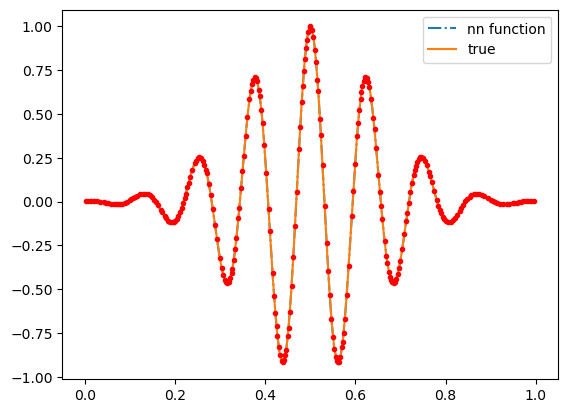

time taken:  14.209318399429321
neuron num 		 error 		 order
4 		 0.387805 		 * 		 18.401153 		 * 

8 		 0.443461 		 -0.193475 		 17.786777 		 0.048991 

16 		 0.155684 		 1.510189 		 7.723220 		 1.203531 

32 		 0.004744 		 5.036291 		 0.565187 		 3.772402 

64 		 0.000200 		 4.565185 		 0.055311 		 3.353098 

128 		 0.000012 		 4.032914 		 0.007297 		 2.922138 

256 		 0.000001 		 4.050857 		 0.000879 		 3.052628 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.387805 &		 * & 		 18.401153 & 		 *  \\ \hline  

8 		 &  4.435e-01 &  		 -0.19 &  		 1.779e+01 &  		 0.05 \\ \hline  

16 		 &  1.557e-01 &  		 1.51 &  		 7.723e+00 &  		 1.20 \\ \hline  

32 		 &  4.744e-03 &  		 5.04 &  		 5.652e-01 &  		 3.77 \\ \hline  

64 		 &  2.004e-04 &  		 4.57 &  		 5.531e-02 &  		 3.35 \\ \hline  

128 		 &  1.224e-05 &  		 4.03 &  		 7.297e-03 &  		 2.92 \\ \hline  

256 		 &  7.387e-07 &  		 4.05 &  		 8.795e-04 &  		 3.05 \\ \hline  



In [65]:
# sigma = 0.15
# m = 8

import torch
import math

# Parameters for the Gabor function
sigma = 0.15
m = 8


def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term

def du_exact(x):
    """First derivative of the Gabor function with respect to each component for a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Derivative with respect to x_1
    du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)

    # Derivative with respect to other dimensions
    du_dx_other = exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term

    # Concatenate all the derivatives to keep dimension
    du_dx = torch.cat([du_dx1, du_dx_other], dim=1)

    return du_dx

def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term 
    - (2 * math.pi * m * exp_term * sin_term) 
    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * (((x[:, 1:] - 0.5) ** 2 / sigma ** 2) - 1) * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(x):
    return du_exact(x) 


function_name = "gabor1d" 
filename_write = "data/1DOGA-PBE-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 
relu_k = 3 
for N in [2**8]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**13
    order = 3
    exponent = 8
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGARandPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)



# # Example usage:
# # Define a batch of points as rows in a 2D tensor
# x_batch = torch.tensor([[0.5], [0.25], [0.1]])  # Example points in 2D

# gabor_vals = gabor_function(x_batch)
# gabor_derivs = gabor_derivative(x_batch)
# gabor_laplacians = gabor_laplacian(x_batch)
# rhs_vals = rhs(x_batch)

# print(f"Gabor Function Values: {gabor_vals}")
# print(f"Gabor Derivatives: {gabor_derivs}")
# print(f"Gabor Laplacians (summed): {gabor_laplacians}")
# print(f"Right-hand side values: {rhs_vals}")


# x_coord = torch.linspace(0,1,100).view(-1,1)
# print(gabor_function(x_coord).size())

# plt.plot(x_coord,gabor_function(x_coord) )
# plt.show()

using linear solver:  direct
epoch:  1
torch.Size([2, 256])
one output
argmax time:  0.0016002655029296875
selected neuron index:  tensor(148, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0037105, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:0.006580737380933074 	 residual l2 norm: 0.015362455570828479 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:1.17476984940005e-09 	 residual l2 norm: 2.7424524179364695e-09 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:3.329062589514993e-16 	 residual l2 norm: 7.771561172376096e-16 
converged at iteration:  3
sol_update_l2_norm:3.329062589514993e-16 	 residual l2 norm: 7.771561172376096e-16 
epoch:  2
torch.Size([2, 256])
two outputs
argmax time:  0.0018906593322753906
selected neuron index:  tensor(149, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9798071, device='cuda:0')
newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:0.01009026569939524 	 residual l2 norm: 

two outputs
argmax time:  0.002070903778076172
selected neuron index:  tensor(129, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1040051, device='cuda:0')
assembling the matrix time taken:  0.0001575946807861328
solving Ax = b time taken:  0.0001926422119140625
newton iteration:  1
torch.Size([1, 19])
sol_update_l2_norm:95662.18441124428 	 residual l2 norm: 0.00011440264061241742 
newton iteration:  2
torch.Size([1, 19])
sol_update_l2_norm:0.11224981897242745 	 residual l2 norm: 7.984782419124086e-07 
newton iteration:  3
torch.Size([1, 19])
sol_update_l2_norm:2.8169292899392356e-07 	 residual l2 norm: 1.1019170101221901e-11 
converged at iteration:  3
sol_update_l2_norm:2.8169292899392356e-07 	 residual l2 norm: 1.1019170101221901e-11 
epoch:  20
torch.Size([2, 256])
two outputs
argmax time:  0.0019059181213378906
selected neuron index:  tensor(185, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3240393, device='cuda:0')
assembling the matrix time taken:  0.0001580715

torch.Size([1, 29])
sol_update_l2_norm:4.559380981590062e-05 	 residual l2 norm: 2.779558135270285e-11 
newton iteration:  6
torch.Size([1, 29])
sol_update_l2_norm:4.256170365697598e-05 	 residual l2 norm: 2.868785840141608e-11 
newton iteration:  7
torch.Size([1, 29])
sol_update_l2_norm:3.5519914135245456e-05 	 residual l2 norm: 2.5301946630762635e-11 
newton iteration:  8
torch.Size([1, 29])
sol_update_l2_norm:4.294691356909925e-05 	 residual l2 norm: 2.82892932820605e-11 
newton iteration:  9
torch.Size([1, 29])
sol_update_l2_norm:3.5323742477520526e-05 	 residual l2 norm: 2.2271942792568708e-11 
newton iteration:  10
torch.Size([1, 29])
sol_update_l2_norm:2.0586063337333665e-05 	 residual l2 norm: 2.070120611718953e-11 
newton iteration:  11
torch.Size([1, 29])
sol_update_l2_norm:4.9273005795288695e-05 	 residual l2 norm: 2.6863741942334777e-11 
newton iteration:  12
torch.Size([1, 29])
sol_update_l2_norm:2.282566825447304e-05 	 residual l2 norm: 6.131165341695699e-12 
newton itera

torch.Size([1, 34])
sol_update_l2_norm:9.112978441834869e-05 	 residual l2 norm: 5.461675984631183e-12 
newton iteration:  12
torch.Size([1, 34])
sol_update_l2_norm:5.599805824231809e-05 	 residual l2 norm: 1.789605623821782e-11 
newton iteration:  13
torch.Size([1, 34])
sol_update_l2_norm:9.298014919201823e-05 	 residual l2 norm: 6.804502256110205e-12 
newton iteration:  14
torch.Size([1, 34])
sol_update_l2_norm:8.591394066820304e-05 	 residual l2 norm: 3.6519008679191566e-12 
newton iteration:  15
torch.Size([1, 34])
sol_update_l2_norm:0.0002574796699930342 	 residual l2 norm: 1.814513783886612e-11 
newton iteration:  16
torch.Size([1, 34])
sol_update_l2_norm:0.00018660961338902803 	 residual l2 norm: 7.00722696978335e-12 
newton iteration:  17
torch.Size([1, 34])
sol_update_l2_norm:0.00020206866849302064 	 residual l2 norm: 4.2206343646565006e-11 
newton iteration:  18
torch.Size([1, 34])
sol_update_l2_norm:0.000132484959869276 	 residual l2 norm: 1.8509840321852562e-11 
newton iter

sol_update_l2_norm:134169.71743621316 	 residual l2 norm: 0.0004401153588061423 
newton iteration:  2
torch.Size([1, 39])
sol_update_l2_norm:24.59018320344685 	 residual l2 norm: 4.489302380832253e-09 
newton iteration:  3
torch.Size([1, 39])
sol_update_l2_norm:0.007522134721320576 	 residual l2 norm: 3.23308577406867e-11 
newton iteration:  4
torch.Size([1, 39])
sol_update_l2_norm:0.0011329298836161863 	 residual l2 norm: 1.3077881584776752e-11 
newton iteration:  5
torch.Size([1, 39])
sol_update_l2_norm:0.00029026028353089833 	 residual l2 norm: 1.541230762666469e-11 
newton iteration:  6
torch.Size([1, 39])
sol_update_l2_norm:0.001528951646562672 	 residual l2 norm: 1.7876057123886106e-11 
newton iteration:  7
torch.Size([1, 39])
sol_update_l2_norm:0.0027136177323640607 	 residual l2 norm: 2.2328605027493343e-11 
newton iteration:  8
torch.Size([1, 39])
sol_update_l2_norm:0.002466568136846194 	 residual l2 norm: 3.580133996318882e-11 
newton iteration:  9
torch.Size([1, 39])
sol_upd

torch.Size([1, 43])
sol_update_l2_norm:0.0021872775313581784 	 residual l2 norm: 9.529062159009927e-12 
newton iteration:  15
torch.Size([1, 43])
sol_update_l2_norm:0.002950638146486301 	 residual l2 norm: 8.958380837527412e-12 
newton iteration:  16
torch.Size([1, 43])
sol_update_l2_norm:0.0006573504426911081 	 residual l2 norm: 1.1548631384520014e-11 
newton iteration:  17
torch.Size([1, 43])
sol_update_l2_norm:0.0008043984528433944 	 residual l2 norm: 1.873514773850577e-11 
newton iteration:  18
torch.Size([1, 43])
sol_update_l2_norm:0.0006777374298536478 	 residual l2 norm: 2.191331164757422e-11 
newton iteration:  19
torch.Size([1, 43])
sol_update_l2_norm:0.001132179704194417 	 residual l2 norm: 1.8191550354641852e-11 
newton iteration:  20
torch.Size([1, 43])
sol_update_l2_norm:0.0009733036261598993 	 residual l2 norm: 2.209127410457062e-11 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.0009733036261598993 	 residual l2 norm: 2.209127410457062e-11 
epoch:  44


torch.Size([1, 48])
sol_update_l2_norm:0.6992528800369738 	 residual l2 norm: 1.8456709876067197e-11 
newton iteration:  4
torch.Size([1, 48])
sol_update_l2_norm:0.004427247969783336 	 residual l2 norm: 1.515520900498594e-11 
newton iteration:  5
torch.Size([1, 48])
sol_update_l2_norm:0.0018314516285207372 	 residual l2 norm: 1.531668228684882e-11 
newton iteration:  6
torch.Size([1, 48])
sol_update_l2_norm:0.0016465836521187922 	 residual l2 norm: 2.4000496919648894e-11 
newton iteration:  7
torch.Size([1, 48])
sol_update_l2_norm:0.005439105895056104 	 residual l2 norm: 1.878232785283102e-11 
newton iteration:  8
torch.Size([1, 48])
sol_update_l2_norm:0.002941610133453521 	 residual l2 norm: 1.5927711896143695e-11 
newton iteration:  9
torch.Size([1, 48])
sol_update_l2_norm:0.001403479501659063 	 residual l2 norm: 1.6578607576586776e-11 
newton iteration:  10
torch.Size([1, 48])
sol_update_l2_norm:0.0025340554058056 	 residual l2 norm: 4.240952355509382e-11 
newton iteration:  11
torc

torch.Size([1, 52])
sol_update_l2_norm:0.0022818158335323143 	 residual l2 norm: 3.519280095235081e-11 
newton iteration:  14
torch.Size([1, 52])
sol_update_l2_norm:0.005194068668059964 	 residual l2 norm: 3.061942188169322e-11 
newton iteration:  15
torch.Size([1, 52])
sol_update_l2_norm:0.0024037220594811874 	 residual l2 norm: 7.729209909925602e-12 
newton iteration:  16
torch.Size([1, 52])
sol_update_l2_norm:0.003332625133973379 	 residual l2 norm: 1.2422628525244986e-11 
newton iteration:  17
torch.Size([1, 52])
sol_update_l2_norm:0.0027564231182138047 	 residual l2 norm: 6.4847742027333865e-12 
newton iteration:  18
torch.Size([1, 52])
sol_update_l2_norm:0.005529152307374446 	 residual l2 norm: 9.284782589153456e-12 
newton iteration:  19
torch.Size([1, 52])
sol_update_l2_norm:0.0030246399659803265 	 residual l2 norm: 1.3206232461714309e-11 
newton iteration:  20
torch.Size([1, 52])
sol_update_l2_norm:0.0040970188103687305 	 residual l2 norm: 5.13915713385977e-12 
Newton solver N

assembling the matrix time taken:  0.00015544891357421875
solving Ax = b time taken:  0.0004220008850097656
newton iteration:  1
torch.Size([1, 57])
sol_update_l2_norm:380465.1186626444 	 residual l2 norm: 0.008989914126321769 
newton iteration:  2
torch.Size([1, 57])
sol_update_l2_norm:890.6252401125384 	 residual l2 norm: 2.299376865800177e-09 
newton iteration:  3
torch.Size([1, 57])
sol_update_l2_norm:4.676128338512473 	 residual l2 norm: 2.4228663186965518e-11 
newton iteration:  4
torch.Size([1, 57])
sol_update_l2_norm:0.021575971989018707 	 residual l2 norm: 2.0109107415697517e-11 
newton iteration:  5
torch.Size([1, 57])
sol_update_l2_norm:0.006613293331000042 	 residual l2 norm: 1.999992893974141e-11 
newton iteration:  6
torch.Size([1, 57])
sol_update_l2_norm:0.010472874539077139 	 residual l2 norm: 4.382207507451414e-12 
newton iteration:  7
torch.Size([1, 57])
sol_update_l2_norm:0.01474385010056555 	 residual l2 norm: 2.084702025993234e-11 
newton iteration:  8
torch.Size([

torch.Size([1, 61])
sol_update_l2_norm:0.014121364944380313 	 residual l2 norm: 1.1865415280559963e-11 
newton iteration:  10
torch.Size([1, 61])
sol_update_l2_norm:0.011243476439527712 	 residual l2 norm: 2.3329223295923786e-11 
newton iteration:  11
torch.Size([1, 61])
sol_update_l2_norm:0.0192100440673298 	 residual l2 norm: 1.2569361083649781e-11 
newton iteration:  12
torch.Size([1, 61])
sol_update_l2_norm:0.02573435859405082 	 residual l2 norm: 2.957642435433278e-11 
newton iteration:  13
torch.Size([1, 61])
sol_update_l2_norm:0.020819317178084717 	 residual l2 norm: 3.1626692757615086e-11 
newton iteration:  14
torch.Size([1, 61])
sol_update_l2_norm:0.013772084733254192 	 residual l2 norm: 2.0521683766269242e-11 
newton iteration:  15
torch.Size([1, 61])
sol_update_l2_norm:0.011347311721321498 	 residual l2 norm: 1.8230763180254933e-11 
newton iteration:  16
torch.Size([1, 61])
sol_update_l2_norm:0.013265732886816836 	 residual l2 norm: 2.2108661459180835e-11 
newton iteration: 

torch.Size([1, 65])
sol_update_l2_norm:0.07000934555915382 	 residual l2 norm: 1.869977000007692e-11 
newton iteration:  19
torch.Size([1, 65])
sol_update_l2_norm:0.09181730727480387 	 residual l2 norm: 2.3353283504520847e-11 
newton iteration:  20
torch.Size([1, 65])
sol_update_l2_norm:0.023451206906456752 	 residual l2 norm: 1.3161064563613568e-11 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.023451206906456752 	 residual l2 norm: 1.3161064563613568e-11 
epoch:  66
torch.Size([2, 256])
two outputs
argmax time:  0.0018160343170166016
selected neuron index:  tensor(181, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3812069, device='cuda:0')
assembling the matrix time taken:  0.00015425682067871094
solving Ax = b time taken:  0.0003502368927001953
newton iteration:  1
torch.Size([1, 66])
sol_update_l2_norm:1079671.312258269 	 residual l2 norm: 0.015763141782364716 
newton iteration:  2
torch.Size([1, 66])
sol_update_l2_norm:7659.569149029277 	 residual l2 n

torch.Size([1, 70])
sol_update_l2_norm:11349910.829248488 	 residual l2 norm: 0.21244431106302064 
newton iteration:  2
torch.Size([1, 70])
sol_update_l2_norm:68734.41480259175 	 residual l2 norm: 3.91665090417946e-07 
newton iteration:  3
torch.Size([1, 70])
sol_update_l2_norm:1174.9947225261249 	 residual l2 norm: 2.7842312014790404e-11 
newton iteration:  4
torch.Size([1, 70])
sol_update_l2_norm:24.45623122855664 	 residual l2 norm: 2.8916145196722196e-11 
newton iteration:  5
torch.Size([1, 70])
sol_update_l2_norm:0.36543743484170765 	 residual l2 norm: 2.6603440083474123e-11 
newton iteration:  6
torch.Size([1, 70])
sol_update_l2_norm:0.053938923649660575 	 residual l2 norm: 7.55007795998228e-12 
newton iteration:  7
torch.Size([1, 70])
sol_update_l2_norm:0.11046789392584262 	 residual l2 norm: 1.7924745309733396e-11 
newton iteration:  8
torch.Size([1, 70])
sol_update_l2_norm:0.06225973704065239 	 residual l2 norm: 2.7507037404887193e-11 
newton iteration:  9
torch.Size([1, 70])


torch.Size([1, 74])
sol_update_l2_norm:0.09766514694967787 	 residual l2 norm: 4.9143637182385136e-12 
newton iteration:  7
torch.Size([1, 74])
sol_update_l2_norm:0.12902661859558967 	 residual l2 norm: 5.4882805423630134e-12 
newton iteration:  8
torch.Size([1, 74])
sol_update_l2_norm:0.05091341340479101 	 residual l2 norm: 1.9494912234056842e-11 
newton iteration:  9
torch.Size([1, 74])
sol_update_l2_norm:0.07065155384802262 	 residual l2 norm: 9.105522341816655e-12 
newton iteration:  10
torch.Size([1, 74])
sol_update_l2_norm:0.11567051439477906 	 residual l2 norm: 2.344517456906976e-11 
newton iteration:  11
torch.Size([1, 74])
sol_update_l2_norm:0.1074328152146313 	 residual l2 norm: 1.2725915870573414e-11 
newton iteration:  12
torch.Size([1, 74])
sol_update_l2_norm:0.0798017374654519 	 residual l2 norm: 5.547294755280077e-12 
newton iteration:  13
torch.Size([1, 74])
sol_update_l2_norm:0.04538617374624592 	 residual l2 norm: 2.7758865596684066e-11 
newton iteration:  14
torch.Si

torch.Size([1, 78])
sol_update_l2_norm:0.3530600653381426 	 residual l2 norm: 2.0211002141230605e-11 
newton iteration:  12
torch.Size([1, 78])
sol_update_l2_norm:0.15728821190469258 	 residual l2 norm: 4.445611983208752e-12 
newton iteration:  13
torch.Size([1, 78])
sol_update_l2_norm:0.2339914414261557 	 residual l2 norm: 1.0212230729680389e-11 
newton iteration:  14
torch.Size([1, 78])
sol_update_l2_norm:0.09258137137582442 	 residual l2 norm: 3.3686758068248506e-11 
newton iteration:  15
torch.Size([1, 78])
sol_update_l2_norm:0.12059720253651629 	 residual l2 norm: 1.913584721636934e-11 
newton iteration:  16
torch.Size([1, 78])
sol_update_l2_norm:0.27315395208513876 	 residual l2 norm: 2.7998597305476382e-12 
newton iteration:  17
torch.Size([1, 78])
sol_update_l2_norm:0.23936165544811722 	 residual l2 norm: 1.78979890319907e-11 
newton iteration:  18
torch.Size([1, 78])
sol_update_l2_norm:0.3606825606505871 	 residual l2 norm: 5.87750226975222e-12 
newton iteration:  19
torch.Siz

torch.Size([1, 82])
sol_update_l2_norm:28.374092499547547 	 residual l2 norm: 3.4266246744297354e-11 
newton iteration:  16
torch.Size([1, 82])
sol_update_l2_norm:13.416283268734434 	 residual l2 norm: 3.471280519277907e-12 
newton iteration:  17
torch.Size([1, 82])
sol_update_l2_norm:6.2610347678969385 	 residual l2 norm: 2.1852744514196476e-11 
newton iteration:  18
torch.Size([1, 82])
sol_update_l2_norm:2.7844258415522516 	 residual l2 norm: 1.3220744804803649e-11 
newton iteration:  19
torch.Size([1, 82])
sol_update_l2_norm:0.8178045308936169 	 residual l2 norm: 1.0545919322992975e-11 
newton iteration:  20
torch.Size([1, 82])
sol_update_l2_norm:0.7226892948348839 	 residual l2 norm: 5.778288441467646e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.7226892948348839 	 residual l2 norm: 5.778288441467646e-12 
epoch:  83
torch.Size([2, 256])
two outputs
argmax time:  0.001829385757446289
selected neuron index:  tensor(180, device='cuda:0') tensor(1., device='cud

torch.Size([1, 86])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 86])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 86])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  87
torch.Size([2, 256])
two outputs
argmax time:  0.0018463134765625
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7236001, device='cuda:0')
assembling the matrix time taken:  0.0001575946807861328
solving Ax = b time taken:  0.0004532337188720703
newton iteration:  1
torch.Size([1, 87])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 87])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 87])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 87])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newt

torch.Size([1, 90])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 90])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  91
torch.Size([2, 256])
two outputs
argmax time:  0.0018472671508789062
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9070962, device='cuda:0')
assembling the matrix time taken:  0.00015807151794433594
solving Ax = b time taken:  0.0004718303680419922
newton iteration:  1
torch.Size([1, 91])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 91])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 91])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 91])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 91])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
n

torch.Size([1, 94])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 94])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  95
torch.Size([2, 256])
two outputs
argmax time:  0.0018613338470458984
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4282574, device='cuda:0')
assembling the matrix time taken:  0.0001609325408935547
solving Ax = b time taken:  0.0004901885986328125
newton iteration:  1
torch.Size([1, 95])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 95])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 95])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 95])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 95])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
ne

torch.Size([1, 98])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 98])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 98])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 98])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  99
torch.Size([2, 256])
two outputs
argmax time:  0.0018434524536132812
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5676958, device='cuda:0')
assembling the matrix time taken:  0.00015807151794433594
solving Ax = b time taken:  0.0005390644073486328
newton iteration:  1
torch.Size([1, 99])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 99])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 99])
sol_update_l2_norm:nan 	 residual l2 norm: nan 

torch.Size([1, 102])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 102])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 102])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 102])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 102])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  103
torch.Size([2, 256])
two outputs
argmax time:  0.001848459243774414
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3574771, device='cuda:0')
assembling the matrix time taken:  0.0001575946807861328
solving Ax = b time taken:  0.0005564689636230469
newton iteration:  1
torch.Size([1, 103])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 103])
sol_update_l2_norm:nan 	 residual l2 nor

torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 106])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  107
torch.Size([2, 256])
two outputs
argmax time:  0.0018382072448730469
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3890127, device='cuda:0')
assembling the matrix time taken:  0.000156402587890625
solving Ax = b time taken:  0.0005710124

torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 110])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  111
torch.Size([2, 256])
two outputs
argmax time:  0.0018510818481445312
selected neuron index:  tenso

torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 114])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20

torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 118])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
tor

assembling the matrix time taken:  0.00015687942504882812
solving Ax = b time taken:  0.0006470680236816406
newton iteration:  1
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 122])
sol_update_l2_norm:nan 	 residual l2 no

torch.Size([1, 125])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 125])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 125])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  126
torch.Size([2, 256])
two outputs
argmax time:  0.0018723011016845703
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2227290, device='cuda:0')
assembling the matrix time taken:  0.0001513957977294922
solving Ax = b time taken:  0.0006814002990722656
newton iteration:  1
torch.Size([1, 126])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 126])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 126])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 126])
sol_update_l2_norm:nan 	 residual l2 norm

torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 129])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  130
torch.Size([2, 256])
two outputs
argmax time:  0.001886129379272461
selected neuron index:  tensor

torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 136])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  137
torch.Size([2, 256])
two outputs
argmax time:  0.0018994808197021484
selected neuron index:  tenso

newton iteration:  8
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 143])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
n

two outputs
argmax time:  0.00199127197265625
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8314167, device='cuda:0')
assembling the matrix time taken:  0.00015616416931152344
solving Ax = b time taken:  0.0009176731109619141
newton iteration:  1
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 150])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iter

torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 156])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
t

torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 162])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  163
torch.Size([2, 256])
two outputs
argmax time:  0.001932382583618164
selected neuron index:  tensor

torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 168])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  169
torch.Size([2, 256])
two outputs
argmax time:  0.001947164535522461
selected neuron index:  tensor

torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 174])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20

torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 180])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch

torch.Size([1, 185])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 185])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 185])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 185])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 185])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 185])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  186
torch.Size([2, 256])
two outputs
argmax time:  0.001978158950805664
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2320648, device='cuda:0')
assembling the matrix time taken:  0.00016021728515625
solving Ax = b time taken:  0.0011563301086425781
newton iteration:  1
torch.Size([1, 186])
sol_update_l2_norm:nan 	 residual l2 norm

torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 191])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.S

torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 196])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
t

torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 201])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT con

torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 206])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  207
torch.Size([2, 256])
two outputs
argmax time:  0.002015829086303711
selected neuron index:  tensor

torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 211])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  212
torch.S

torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 216])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19


torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 221])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.

torch.Size([1, 225])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 225])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 225])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 225])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  226
torch.Size([2, 256])
two outputs
argmax time:  0.0020325183868408203
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6277667, device='cuda:0')
assembling the matrix time taken:  0.00016689300537109375
solving Ax = b time taken:  0.00147247314453125
newton iteration:  1
torch.Size([1, 226])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 226])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 226])
sol_update_l2_norm:nan 	 residual l2 norm

torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 230])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19


torch.Size([1, 234])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  235
torch.Size([2, 256])
two outputs
argmax time:  0.0020449161529541016
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1838427, device='cuda:0')
assembling the matrix time taken:  0.00015354156494140625
solving Ax = b time taken:  0.0015118122100830078
newton iteration:  1
torch.Size([1, 235])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 235])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 235])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 235])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 235])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 235])
sol_update_l2_norm:nan 	 residual l2 norm:

torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 239])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19


torch.Size([1, 243])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 243])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 243])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 243])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 
epoch:  244
torch.Size([2, 256])
two outputs
argmax time:  0.002049684524536133
selected neuron index:  tensor(0, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5122321, device='cuda:0')
assembling the matrix time taken:  0.0001544952392578125
solving Ax = b time taken:  0.0015730857849121094
newton iteration:  1
torch.Size([1, 244])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  2
torch.Size([1, 244])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 244])
sol_update_l2_norm:nan 	 residual l2 norm

torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  3
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  4
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  5
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  6
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  7
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  8
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 248])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.

torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  9
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  10
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  11
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  12
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  13
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  14
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 252])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19


torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  15
torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  16
torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  17
torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  18
torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  19
torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
newton iteration:  20
torch.Size([1, 256])
sol_update_l2_norm:nan 	 residual l2 norm: nan 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:nan 	 residual l2 norm: nan 


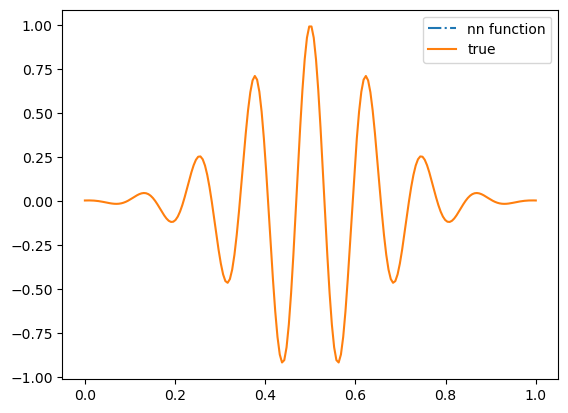

time taken:  15.064125299453735
neuron num 		 error 		 order
4 		 0.364655 		 * 		 18.407223 		 * 

8 		 0.367527 		 -0.011319 		 18.400647 		 0.000516 

16 		 0.243537 		 0.593709 		 11.986168 		 0.618386 

32 		 0.003128 		 6.282714 		 0.351616 		 5.091225 

64 		 0.000050 		 5.979906 		 0.012119 		 4.858665 

128 		 nan 		 nan 		 nan 		 nan 

256 		 nan 		 nan 		 nan 		 nan 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.364655 &		 * & 		 18.407223 & 		 *  \\ \hline  

8 		 &  3.675e-01 &  		 -0.01 &  		 1.840e+01 &  		 0.00 \\ \hline  

16 		 &  2.435e-01 &  		 0.59 &  		 1.199e+01 &  		 0.62 \\ \hline  

32 		 &  3.128e-03 &  		 6.28 &  		 3.516e-01 &  		 5.09 \\ \hline  

64 		 &  4.956e-05 &  		 5.98 &  		 1.212e-02 &  		 4.86 \\ \hline  

128 		 &  nan &  		 nan &  		 nan &  		 nan \\ \hline  

256 		 &  nan &  		 nan &  		 nan &  		 nan \\ \hline  



In [67]:
# sigma = 0.15
# m = 8

import torch
import math

# Parameters for the Gabor function
sigma = 0.15
m = 8


def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term

def du_exact(x):
    """First derivative of the Gabor function with respect to each component for a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Derivative with respect to x_1
    du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)

    # Derivative with respect to other dimensions
    du_dx_other = exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term

    # Concatenate all the derivatives to keep dimension
    du_dx = torch.cat([du_dx1, du_dx_other], dim=1)

    return du_dx

def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term 
    - (2 * math.pi * m * exp_term * sin_term) 
    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * (((x[:, 1:] - 0.5) ** 2 / sigma ** 2) - 1) * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(x):
    return du_exact(x) 


function_name = "gabor1d" 
filename_write = "data/1DOGA-PBE-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 
relu_k = 4 
for N in [2**8]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**13
    order = 3
    exponent = 8
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGARandPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)



# # Example usage:
# # Define a batch of points as rows in a 2D tensor
# x_batch = torch.tensor([[0.5], [0.25], [0.1]])  # Example points in 2D

# gabor_vals = gabor_function(x_batch)
# gabor_derivs = gabor_derivative(x_batch)
# gabor_laplacians = gabor_laplacian(x_batch)
# rhs_vals = rhs(x_batch)

# print(f"Gabor Function Values: {gabor_vals}")
# print(f"Gabor Derivatives: {gabor_derivs}")
# print(f"Gabor Laplacians (summed): {gabor_laplacians}")
# print(f"Right-hand side values: {rhs_vals}")


# x_coord = torch.linspace(0,1,100).view(-1,1)
# print(gabor_function(x_coord).size())

# plt.plot(x_coord,gabor_function(x_coord) )
# plt.show()

using linear solver:  direct
epoch:  1
torch.Size([2, 4096])
one output
argmax time:  0.0489504337310791
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0., device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:2.3419616341890572 	 residual l2 norm: 3.5910078403909775 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.14769629557264985 	 residual l2 norm: 0.2878770777578126 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:0.0025685703834464712 	 residual l2 norm: 0.00484162273585613 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:7.115611716810024e-07 	 residual l2 norm: 1.3405136876504242e-06 
newton iteration:  5
torch.Size([1, 1])
sol_update_l2_norm:5.4475280663331365e-14 	 residual l2 norm: 1.0262624083878791e-13 
converged at iteration:  5
sol_update_l2_norm:5.4475280663331365e-14 	 residual l2 norm: 1.0262624083878791e-13 
epoch:  2
torch.Size([2, 4096])
two outputs
argmax time:  0.0491

two outputs
argmax time:  0.049300193786621094
selected neuron index:  tensor(3118, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5227051, device='cuda:0')
assembling the matrix time taken:  0.00016379356384277344
solving Ax = b time taken:  0.00015807151794433594
newton iteration:  1
torch.Size([1, 12])
sol_update_l2_norm:513.9794380330698 	 residual l2 norm: 0.0006650835836133873 
newton iteration:  2
torch.Size([1, 12])
sol_update_l2_norm:0.0003177519868573363 	 residual l2 norm: 3.881372641593236e-06 
newton iteration:  3
torch.Size([1, 12])
sol_update_l2_norm:2.547252460185576e-11 	 residual l2 norm: 8.239995777786733e-12 
converged at iteration:  3
sol_update_l2_norm:2.547252460185576e-11 	 residual l2 norm: 8.239995777786733e-12 
epoch:  13
torch.Size([2, 4096])
two outputs
argmax time:  0.04930233955383301
selected neuron index:  tensor(3746, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8293457, device='cuda:0')
assembling the matrix time taken:  0.0001749992

two outputs
argmax time:  0.04951930046081543
selected neuron index:  tensor(795, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3881836, device='cuda:0')
assembling the matrix time taken:  0.0001723766326904297
solving Ax = b time taken:  0.0002722740173339844
newton iteration:  1
torch.Size([1, 24])
sol_update_l2_norm:18.109392560439495 	 residual l2 norm: 5.7536547298101275e-05 
newton iteration:  2
torch.Size([1, 24])
sol_update_l2_norm:7.875699473884867e-07 	 residual l2 norm: 3.861598368456654e-08 
newton iteration:  3
torch.Size([1, 24])
sol_update_l2_norm:7.080062512847931e-10 	 residual l2 norm: 8.069428969671188e-15 
converged at iteration:  3
sol_update_l2_norm:7.080062512847931e-10 	 residual l2 norm: 8.069428969671188e-15 
epoch:  25
torch.Size([2, 4096])
two outputs
argmax time:  0.049315690994262695
selected neuron index:  tensor(914, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4462891, device='cuda:0')
assembling the matrix time taken:  0.000163555145

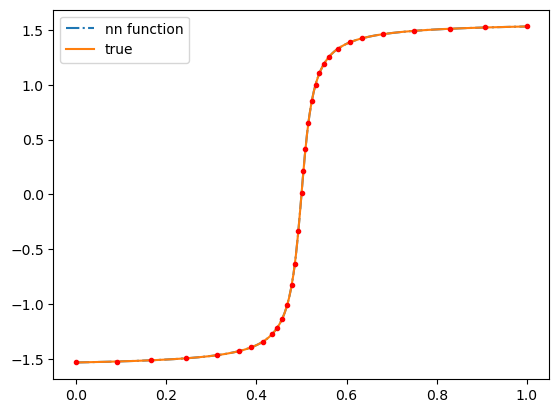

time taken:  2.0056872367858887
neuron num 		 error 		 order
4 		 0.339490 		 * 		 7.055316 		 * 

8 		 0.051539 		 2.719621 		 2.954064 		 1.256009 

16 		 0.001441 		 5.160623 		 0.225172 		 3.713600 

32 		 0.000148 		 3.282814 		 0.062664 		 1.845323 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.339490 &		 * & 		 7.055316 & 		 *  \\ \hline  

8 		 &  5.154e-02 &  		 2.72 &  		 2.954e+00 &  		 1.26 \\ \hline  

16 		 &  1.441e-03 &  		 5.16 &  		 2.252e-01 &  		 3.71 \\ \hline  

32 		 &  1.481e-04 &  		 3.28 &  		 6.266e-02 &  		 1.85 \\ \hline  



In [19]:
# def u_exact(x):
#     return torch.cos(2*pi*x)

# def du_exact(x):
#     return -2 *pi*torch.sin(2*pi*x)

# def rhs(x):
#     return  (2*pi)**2 * torch.cos(2*pi*x) + torch.cos(2*pi*x)**3 

# def g_N(x):
#     return du_exact(x) 

alpha = 50 
def u_exact(x):
    return torch.arctan(alpha * (x-0.5))

def du_exact(x):
    return alpha/(1+(alpha*(x-0.5))**2)
def laplace_u_exact(x):
    return -2*alpha**3*(x-0.5)/(1+(alpha*(x-0.5))**2)**2

def rhs(x):
    return  -laplace_u_exact(x) + torch.sinh(u_exact(x))

def g_N(x):
    return du_exact(x) 


function_name = "sine1d" 
filename_write = "data/1DOGA-PBE-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 
relu_k = 2
for N in [2**11]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**14
    order = 3
    exponent = 5
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGAPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)


#### arctan example 